# Informe del Análisis de Calidad de Datos: 

#### 15 de Noviembre de 2024

Documentar en formato markdown los resultados del análisis de calidad de los datos, identificando problemas encontrados (como valores faltantes o inconsistencias) y detallando las soluciones implementadas para garantizar la confiabilidad del análisis posterior.

## 2. Descripción de los datos de **Fees**

### 1- Enumeración de Campos y Posibles Valores

1. **`status`**  
   - **Descripción:** Estado de las tarifas relacionadas con el Cash Request (CR).  
   - **Posibles valores:**
     - `confirmed`: La tarifa fue creada y confirmada, pero puede no haberse cobrado.
     - `rejected`: El intento de cobro de la tarifa falló.
     - `cancelled`: La tarifa fue creada pero luego anulada por diversas razones.
     - `accepted`: La tarifa fue cobrada exitosamente.

2. **`category`**  
   - **Descripción:** Razón del incidente asociado a la tarifa.  
   - **Posibles valores:**
     - `rejected_direct_debit`: Tarifas por rechazo del débito directo inicial.
     - `month_delay_on_payment`: Tarifas recurrentes por retrasos mensuales en el pago.

3. **`reason`**  
   - **Descripción:** Descripción del incidente o motivo de la tarifa.  
   - **Posibles valores:** Texto descriptivo (campo libre).

4. **`created_at`**  
   - **Descripción:** Fecha y hora en que se creó la tarifa.  
   - **Posibles valores:** Marca de tiempo (ISO 8601).

5. **`updated_at`**  
   - **Descripción:** Fecha y hora de la última actualización de la tarifa.  
   - **Posibles valores:** Marca de tiempo (ISO 8601).

6. **`paid_at`**  
   - **Descripción:** Fecha y hora en que se pagó la tarifa.  
   - **Posibles valores:** Marca de tiempo (ISO 8601) o `null`.

7. **`from_date`**  
   - **Descripción:** Fecha inicial de reembolso para tarifas por aplazamiento.  
   - **Posibles valores:** Fecha (ISO 8601) o `null`.

8. **`to_date`**  
   - **Descripción:** Nueva fecha de reembolso para tarifas por aplazamiento.  
   - **Posibles valores:** Fecha (ISO 8601) o `null`.

9. **`cash_request_id`**  
   - **Descripción:** Identificador único del CR asociado a esta tarifa.  
   - **Posibles valores:** Identificador único.

10. **`total_amount`**  
    - **Descripción:** Monto total de la tarifa, incluido el IVA.  
    - **Posibles valores:** Número positivo (en la moneda correspondiente).

11. **`charge_moment`**  
    - **Descripción:** Momento en que se cobrará la tarifa.  
    - **Posibles valores:**
      - `before`: Cobro en el momento de la creación de la tarifa.
      - `after`: Cobro en el momento del reembolso del CR.

---

### Reflexión y Preparación para el EDA

#### **Campos a analizar en profundidad:**
1. **`status` y `category`:** 
   - Permiten analizar los motivos de fallos o cancelaciones.
   - Pueden indicar cuántas tarifas son rechazadas versus aceptadas.
2. **`total_amount`:** 
   - Analizar distribuciones de montos, promedios, y posibles valores atípicos.
3. **Tiempos (`created_at`, `paid_at`, `from_date`, `to_date`):**
   - Estudiar los intervalos entre fechas para identificar patrones o retrasos en los pagos.
4. **`charge_moment`:**
   - Comparar el rendimiento de tarifas cobradas "antes" versus "después".

#### **Transformaciones necesarias:**
1. **Estandarización temporal:**
   - Asegurar que las marcas de tiempo estén en el mismo formato (ISO 8601).
   - Crear variables derivadas como diferencias entre `created_at` y `paid_at`.
2. **Manejo de valores nulos:**
   - Completar o analizar los campos como `paid_at`, `from_date`, y `to_date` según el contexto.
3. **Agrupación de categorías:**
   - Agrupar razones (`category` y `reason`) para facilitar su interpretación.
4. **Transformación monetaria:**
   - Convertir `total_amount` a una única moneda si el dataset abarca múltiples regiones.
5. **Identificación de outliers:**
   - Detectar montos inusualmente altos o incidentes recurrentes en los estados `rejected` o `cancelled`.

Estas transformaciones permiten un análisis robusto, detectando posibles patrones de fallos, evaluando la efectividad de los cobros y optimizando estrategias futuras.

In [37]:
!pip install --upgrade seaborn statsmodels

# Importar librerías necesarias
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import itertools
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings('ignore')

In [38]:
# Cargar el dataset principal de solicitudes de adelanto en efectivo
cash_request = pd.read_csv('../project_dataset/extract - fees - data analyst - .csv')
# Inspeccionar la estructura y el tipo de datos de 'cash_request'
data = cash_request
data.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21061 entries, 0 to 21060
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               21061 non-null  int64  
 1   cash_request_id  21057 non-null  float64
 2   type             21061 non-null  object 
 3   status           21061 non-null  object 
 4   category         2196 non-null   object 
 5   total_amount     21061 non-null  float64
 6   reason           21061 non-null  object 
 7   created_at       21061 non-null  object 
 8   updated_at       21061 non-null  object 
 9   paid_at          15531 non-null  object 
 10  from_date        7766 non-null   object 
 11  to_date          7766 non-null   object 
 12  charge_moment    21061 non-null  object 
dtypes: float64(2), int64(1), object(10)
memory usage: 2.1+ MB


In [39]:

data.describe()


,id,cash_request_id,total_amount
count,21061.000000,21057.000000,21061.000000
mean,10645.355111,16318.449162,5.000237
std,6099.315256,6656.149949,0.034453
min,1.000000,1456.000000,5.000000
25%,5385.000000,11745.000000,5.000000
50%,10652.000000,17160.000000,5.000000
75%,15925.000000,21796.000000,5.000000
max,21193.000000,27010.000000,10.000000


## 2 Análisis de Calidad de Datos 

El análisis de la calidad de datos es una parte fundamental en el proceso de ciencias de datos.Su objetivo es evaluar la integridad,precisión,consistencia y confiabilidad de los datos utilizados en un proyecto o análisis 

1. **Identificación de valores faltantes**: Este paso implica detectar si hay campos o variables en el conjunto de datos que carecen de valores.Los valores faltantes pueden deberse a diversos motivos,como errores en la entrada de datos,fallas en los sistemas de recolección o simplemente la ausencia de información.
2. **Detección de inconsistencias en los datos**: Consiste en buscar discrepancias o contradicciones entre los datos.Por ejemplo, si en un conjunto de datos sobre ventas se encuentra que el número de productos vendidos en un día es mayor que el inventario inicial, esto podría ser una inconsistencia.
3. **Identificación de posibles errores**: Esto implica buscar valores atípicos, anomalías o datos que no tienen sentido dentro delcontexto delconjunto de datos.Los errores pueden manifestarse de diversas formas,como valores extremadamente altos o bajos que no son representativos del resto de los datos, o datos que violan las restricciones lógicas de un dominio específico.
4. **Evaluación de la consistencia y precisión**: Se refiere a verificar si los datos están en concordancia con las expectativas y reglas del dominio del problema.Esto implica comprobar la coherencia de los datos con respecto a las reglas de negocio y los estándares establecidos.
5. **Limpieza de datos**: Una vez identificados los problemas de calidad de los datos, se procede a corregirlos o eliminarlos.Esto puede implicar imputar valores faltantes,corregir errores evidentes o eliminar registros que no cumplen con ciertos criterios de calidad.

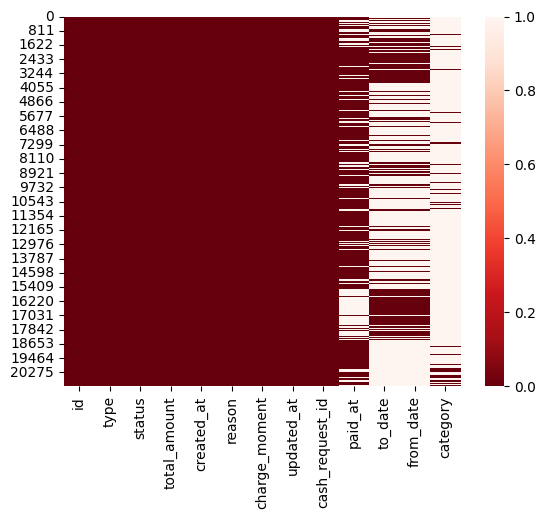

In [40]:
ordered_columns = data.isnull().sum().sort_values().keys()
# Creamos un heatmap con los valores nulos
sns.heatmap(data[ordered_columns].isnull(), annot=False, cmap='Reds_r')
plt.show()

# print('Conclusiones: deleted_account_id y user_id tienen nulos complementarios')
# print('Conclusiones: reco* solo están informadas para aquellos registros afectados')
# print('Conclusiones: moderated_at está menos poblada a medida que pasa el tiempo')
# print('Conclusiones: money_back y raceived están más pobladan a medida que pasa el tiempo')

#### 2.0.1 llenar valores faltantes 

Para llenar valores faltantes en conjuntos de datos tanto cuantitativos como cualitativos,existen varias estrategias comunes que los científicos de datos suelen emplear:
- Valores cuantitativos:
    1. **Imputación por la media o mediana**: Los valores faltantes se reemplazan por la media o mediana de la variable en cuestión.Esta estrategia es simple y efectiva cuando los datos siguen una distribución normal y los valores faltantes son aleatorios.
    2. **Imputación por regresión**: Se utiliza un modelo de regresión para predecir los valores faltantes en función de otras variables del conjunto de datos.Esta técnica es útil cuando existe una correlación significativa entre la variable con valores faltantes y otras variables del conjunto de datos.
    3. **Métodos basados en vecinos más cercanos (KNN)**: Los valores faltantes se im    putan utilizando los valores de las observaciones más similares en función de una métrica de distancia. Esta estrategia es útilcuando las observaciones se pueden agrupar en un espacio métrico.
    4. **Imputación múltiple**: Se generan múltiples imputaciones para los valores faltantes,
    teniendo en cuenta la incertidumbre asociada con la imputación.Esta técnica es útil cuando se desea tener en cuenta la variabilidad en los datos imputados.
- Valores cualitativos:
    1. **Moda o valor más frecuente**: Los valores faltantes se reemplazan por elvalor más común o moda de la variable categórica.Esta estrategia es simple y efectiva cuando hay una categoría dominante en la variable.
    2. **Imputación por regresión logística**: Se utiliza un modelo de regresión logística para predecir la categoría de los valores faltantes en función de otras variables delconjunto de datos.
    3. **Muestreo de valores**: Los valores faltantes se imputan seleccionando aleatoriamente valores observados de la misma variable categórica.
    4. **Imputación basada en modelos de clasificación**: Se utilizan modelos de clasificación (como árboles de decisión o métodos de clasificación más avanzados) para predecir la categoría de los valores faltantes en función de otras variables predictoras.

In [46]:
# Rellenar valores nulos en 'user_id' usando 'deleted_account_id' (clientes transferidos de cuentas eliminadas)
# data.fillna({"user_id": data["deleted_account_id"]}, inplace=True)

# Eliminar la columna 'deleted_account_id' ya que no es necesaria después de la imputación
# data.drop(columns=["deleted_account_id"], inplace=True)

# Estandarización de formatos
#  0   id               21061 non-null  int64  
#  1   cash_request_id  21057 non-null  float64
#  2   type             21061 non-null  object 
#  3   status           21061 non-null  object 
#  4   category         2196 non-null   object 
#  5   total_amount     21061 non-null  float64
#  6   reason           21061 non-null  object 
#  7   created_at       21061 non-null  object 
#  8   updated_at       21061 non-null  object 
#  9   paid_at          15531 non-null  object 
#  10  from_date        7766 non-null   object 
#  11  to_date          7766 non-null   object 
#  12  charge_moment    21061 non-null  object

data['cash_request_id'] = data['cash_request_id'].apply(lambda x: int(x) if x % 1 == 0 else np.nan)

# Convert datetime columns to pandas datetime
datetime_columns = ['created_at', 'updated_at', 'paid_at', 'from_date', 'to_date', 'charge_moment']
for col in datetime_columns:
    data[col] = pd.to_datetime(data[col], errors='coerce').dt.floor('min').dt.tz_localize(None)


data.sort_values(by='id', inplace=True)

# Simplificar reason
data['reason'] = data['reason'].map(lambda x: 'month delay on payment' if x.find('month delay on payment') != -1 else x)
data['reason'] = data['reason'].map(lambda x: 'Postpone Cash Request' if x.find('Postpone Cash Request') != -1 else x)
data['reason'] = data['reason'].map(lambda x: 'Instant Payment Cash Request' if x.find('Instant Payment Cash Request') != -1 else x)

data.head()


,id,cash_request_id,type,status,category,total_amount,reason,created_at,updated_at,paid_at,from_date,to_date,charge_moment
15955,1,2060.0,postpone,cancelled,NaN,5.0,Postpone Cash Request,2020-06-23 08:20:00,2020-10-13 14:25:00,NaT,2020-06-06 22:00:00,NaT,NaT
15821,2,2214.0,postpone,cancelled,NaN,5.0,Postpone Cash Request,2020-06-23 08:20:00,2020-10-13 14:25:00,NaT,2020-06-07 22:00:00,2020-06-22 22:00:00,NaT
1217,3,2069.0,postpone,accepted,NaN,5.0,Postpone Cash Request,2020-06-23 08:20:00,2020-10-13 14:25:00,NaT,2020-06-07 22:00:00,2020-06-22 22:00:00,NaT
15822,4,1655.0,postpone,cancelled,NaN,5.0,Postpone Cash Request,2020-06-23 08:20:00,2020-10-13 14:25:00,NaT,2020-06-07 22:00:00,2020-07-07 22:00:00,NaT
1488,5,2568.0,postpone,accepted,NaN,5.0,Postpone Cash Request,2020-06-09 10:55:00,2020-10-13 14:25:00,NaT,2020-06-26 22:00:00,2020-07-26 22:00:00,NaT


3. **Identificación de posibles errores**: Esto implica buscar valores atípicos, anomalías o datos que no tienen sentido dentro delcontexto delconjunto de datos.Los errores pueden manifestarse de diversas formas,como valores extremadamente altos o bajos que no son representativos del resto de los datos, o datos que violan las restricciones lógicas de un dominio específico.

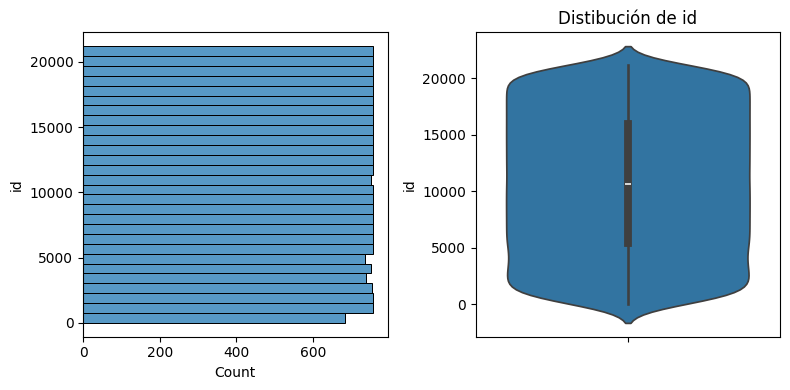

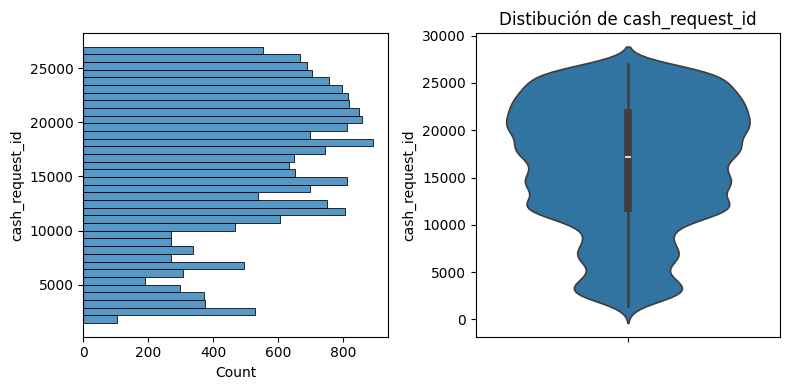

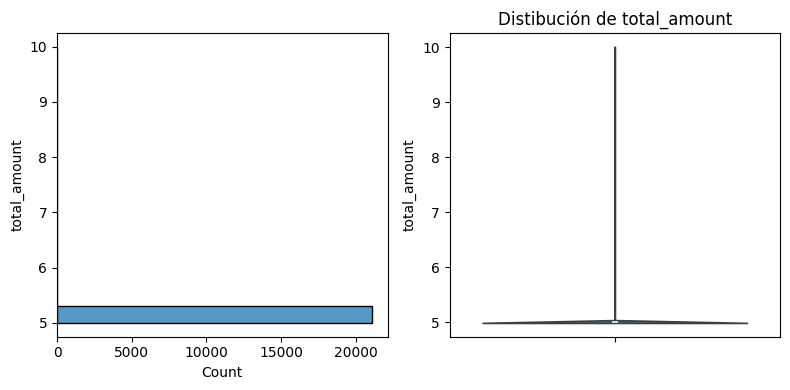

Conclusiones: Existen Amounts de 200, pero nada indica que sean errores


In [42]:
columnas_numericas = data.describe().columns.tolist()

for c in columnas_numericas:
    if data[c].dtype.kind != 'M':
        fig, axs = plt.subplots(1, 2, figsize=(8, 4))
        sns.violinplot(y=c, data=data, ax=axs[1])
        sns.histplot(y=c, data=data, ax=axs[0])
        plt.title(f'Distibución de {c}')
        plt.tight_layout()
        plt.show()


print('Conclusiones: Existen Amounts de 200, pero nada indica que sean errores')

type
instant_payment    11099
postpone            7766
incident            2196
Name: count, dtype: int64

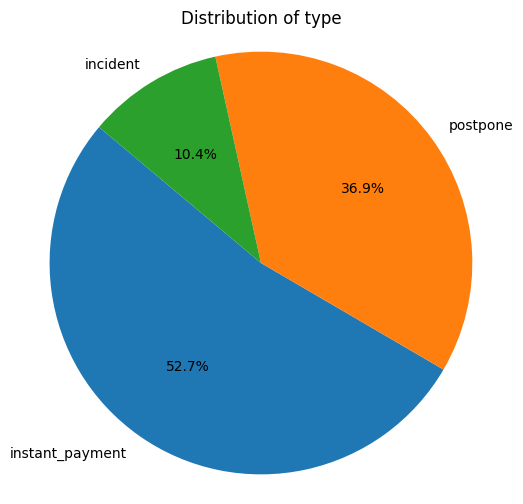

status
accepted     14841
cancelled     4938
rejected      1194
confirmed       88
Name: count, dtype: int64

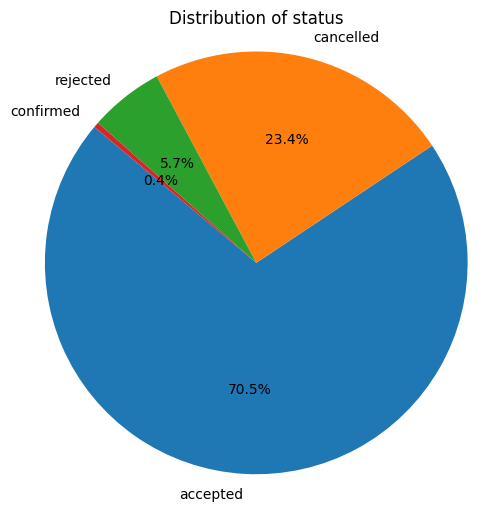

category
rejected_direct_debit     1599
month_delay_on_payment     597
Name: count, dtype: int64

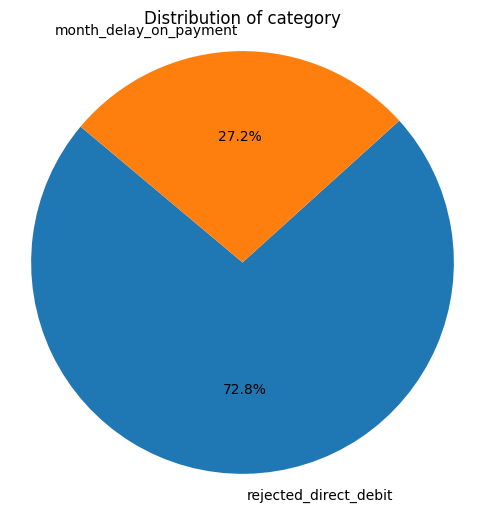

reason
Instant Payment Cash Request    11099
Postpone Cash Request            7766
rejected direct debit            1599
month delay on payment            597
Name: count, dtype: int64

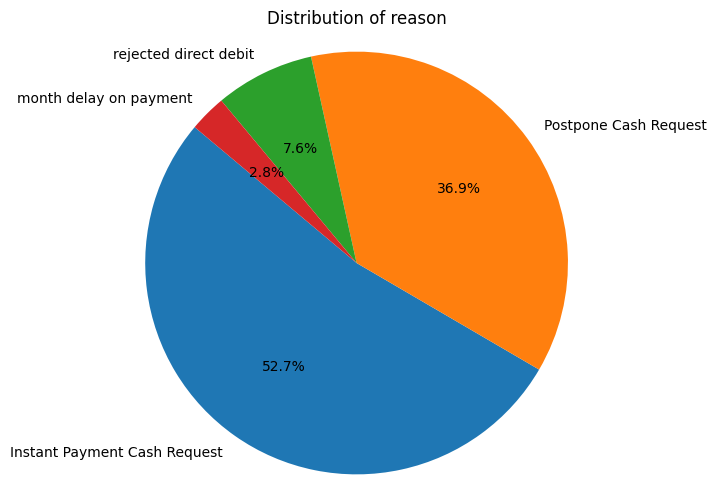

In [43]:
for c in data.columns.tolist():
    if c not in columnas_numericas:
        # Create a pie plot using Seaborn for the 'status' column
        reason_counts = data[c].value_counts()
        display(reason_counts)

        plt.figure(figsize=(6, 6))
        plt.title(f'Distribution of {c}')
        plt.legend = True
        plt.pie(reason_counts, labels=reason_counts.index.tolist(), autopct='%1.1f%%', startangle=140)
        plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
        plt.show()


4. **Evaluación de la consistencia y precisión**: Se refiere a verificar si los datos están en concordancia con las expectativas y reglas del dominio del problema.Esto implica comprobar la coherencia de los datos con respecto a las reglas de negocio y los estándares establecidos.

In [44]:
# Buscar inconsistencias en las fechas

# datetime_columns = ['created_at', 'updated_at', 'moderated_at', 'reimbursement_date', 'money_back_date', 'send_at', 'reco_creation', 'reco_last_update']
data[data['created_at'] > data['updated_at']][['id']].count()
# data[data['reimbursement_date'] > data['money_back_date']][['id']].count()

id    0
dtype: int64

### 3.2 Resumen del Análisis Exploratorio de Datos (AED)

El análisis exploratorio de datos (AED) es la brújula que nos guía a través del vasto territorio de nuestros conjuntos de datos.Nos sumerge en la riqueza de la información,revelando patrones,
tendencias y anomalías que pueden pasar desapercibidas a simple vista.Desde la distribución de calificaciones hasta la correlación entre variables,el AED nos proporciona una comprensión profunda de nuestros datos y nos ayuda a formular hipótesis valiosas para análisis posteriores.

#### 3.2.2 Componentes del AED:

1. **Exploración de Datos Univariable**: Análisis de una variable a la vez para comprender su distribución y estadísticas descriptivas.Este enfoque nos permite entender la naturaleza de cada variable y cómo se distribuyen en el conjunto de datos.
2. **Exploración de Datos Bivariable**: Análisis de la relación entre dos variables para identificar posibles asociaciones o correlaciones.Este análisis nos ayuda a comprender las interacciones entre diferentes variables y su impacto en los resultados.
3. **Identificación de Valores Atípicos**: Detección de puntos que se desvían significativamente de la tendencia general de los datos.La identificación de valores atípicos nos permite comprender mejor la distribución de los datos y evaluar su influencia en nuestros análisis.

### 3.3 Insights de Calidad de Datos 

La calidad de los datos es la piedra angular de cualquier análisis significativo.Los datos incompletos,incorrectos o inconsistentes pueden socavar la validez de nuestros resultados y conducir a conclusiones erróneas.Por lo tanto, es crucial realizar una evaluación rigurosa de la calidad de los datos y tomar medidas para abordar cualquier problema identificado.

#### 3.3.2 Estrategias de Mejora de Calidad de Datos:

1. **Limpieza de Datos**: Identificación y corrección de errores, valores atípicos y datos faltantes.
La limpieza de datos es un proceso esencialpara garantizar la integridad y la precisión de nuestros análisis.
2. **Validación de Datos**: Verificación de la precisión y consistencia de los datos mediante técnicas como la validación cruzada.La validación de datos nos ayuda a confirmar la calidad de nuestros datos y a identificar posibles problemas.
3. **Actualización Regular**: Mantenimiento constante de la integridad de los datos mediante actualizaciones periódicas y revisión continua.La actualización regular de los datos garantiza que estén actualizados y reflejen con precisión la realidad en curso.

### 3.4 Resultados del Análisis de Cohortes 

El análisis de cohortes es una herramienta poderosa para comprender cómo se comportan grupos de individuos a lo largo del tiempo.Al dividir a los usuarios en cohortes basadas en ciertos criterios
(por ejemplo, fecha de inscripción), podemos rastrear su comportamiento y evaluar el impacto de diferentes factores en su experiencia.

#### 3.4.2 Beneficios del Análisis de Cohortes:

1. **Identificación de Tendencias a Largo Plazo**: Permite observar cómo cambian los comportamientos a lo largo del tiempo.El análisis de cohortes nos proporciona una visión a largo plazo de la evolución del comportamiento de los usuarios.
2. **Comparación entre Grupos Homogéneos**: Facilita la comparación de diferentes cohortes con características similares.Esto nos ayuda a comprender mejor las diferencias en elcomportamiento de los usuarios y a identificar áreas de mejora.
3. **Evaluación del Impacto de Intervenciones**: Ayuda a evaluar el efecto de cambios o intervenciones en la experiencia delusuario. El análisis de cohortes nos permite medir el impacto de nuestras acciones y ajustar nuestras estrategias en consecuencia.


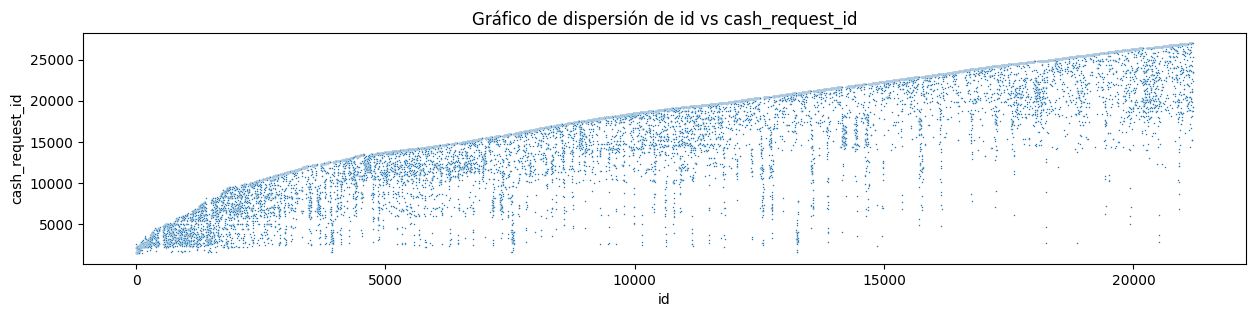

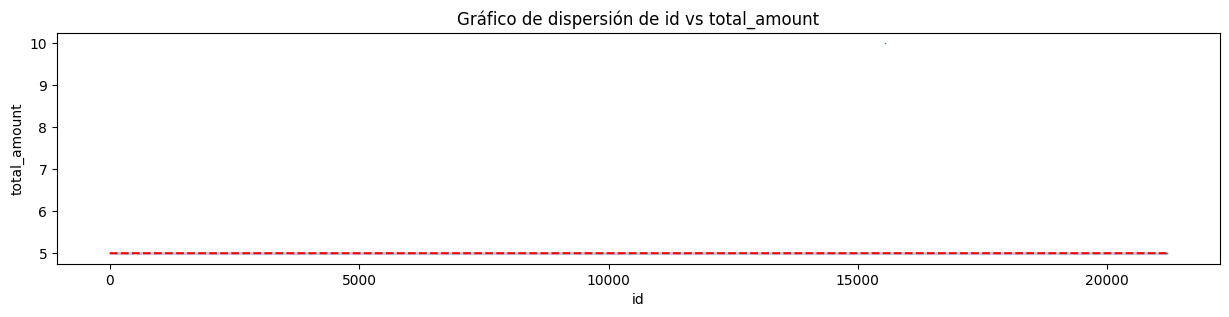

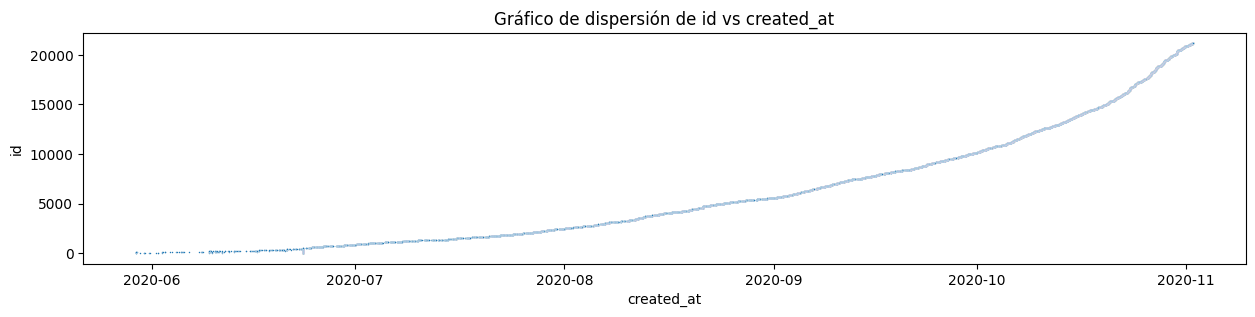

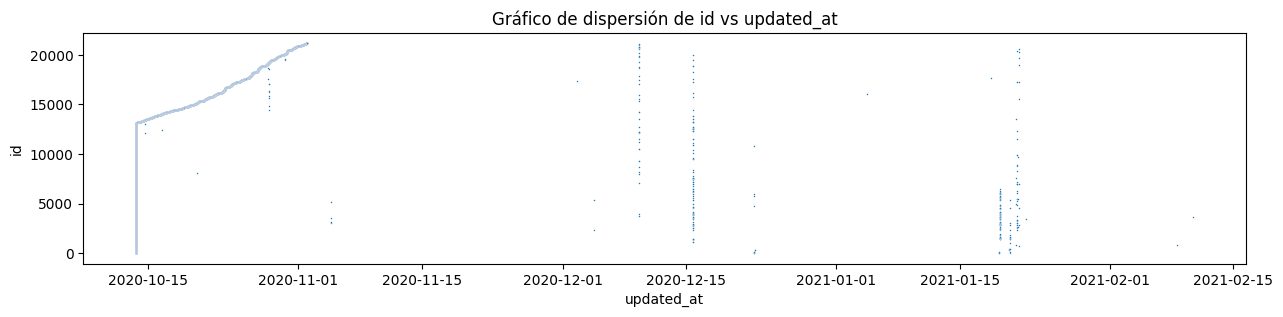

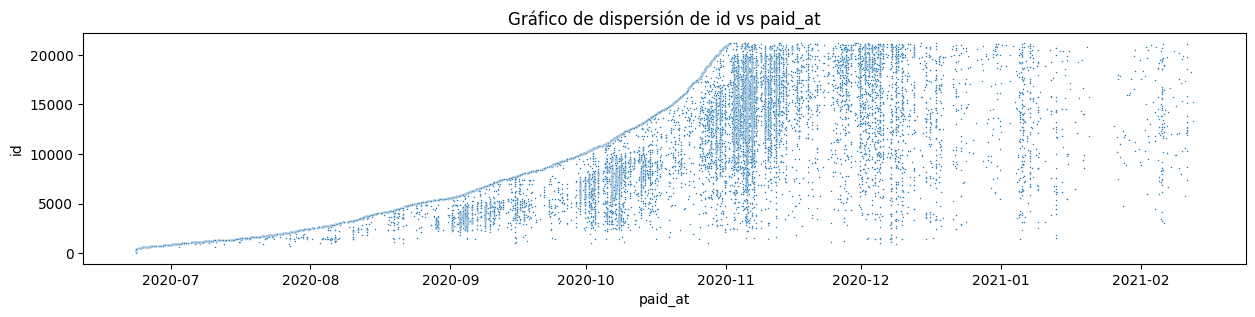

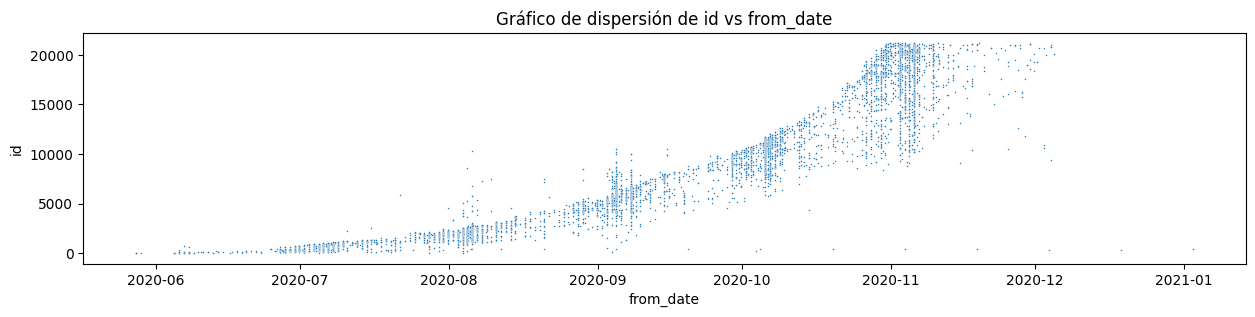

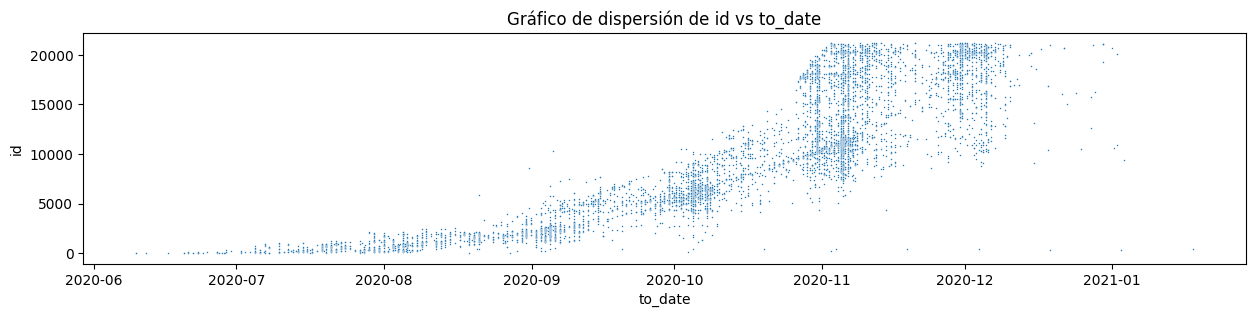

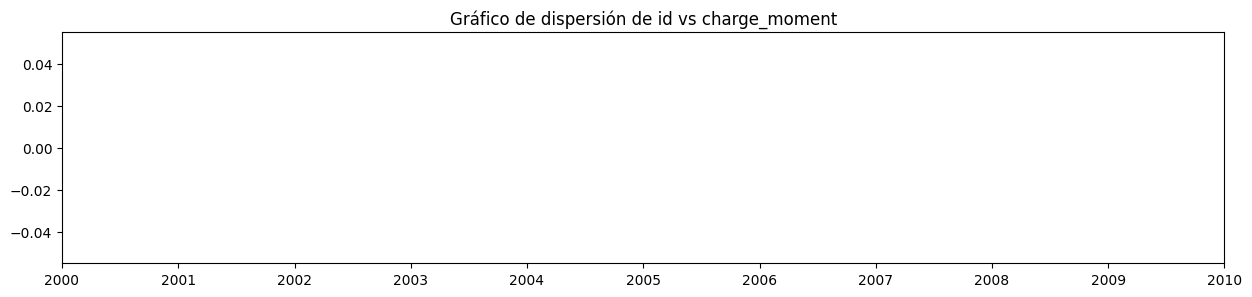

 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  5 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value


LinAlgError: SVD did not converge in Linear Least Squares

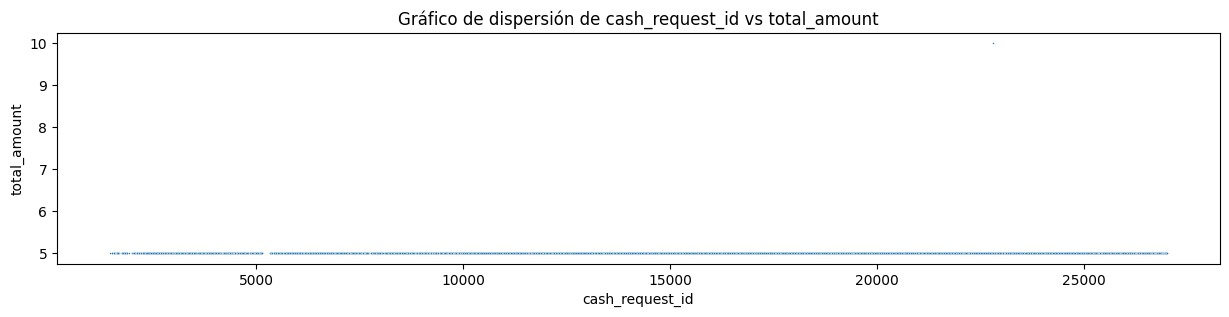

In [45]:
# Genera gráficos de dispersión para todas las combinaciones de columnas numéricas

columnas_numericas=data.describe().columns.tolist()

for c1, c2 in itertools.combinations(columnas_numericas, 2):
    plt.figure(figsize=(15, 3))

    plt.title(f'Gráfico de dispersión de {c1} vs {c2}')
    if data[c1].dtype.kind != 'M' and data[c2].dtype.kind == 'M':
        t = c1
        c1 = c2
        c2 = t
    sns.scatterplot(data=data, x=c1, y=c2, marker='.', s=5)
    if data[c1].dtype.kind != 'M' and data[c2].dtype.kind != 'M':
        z = np.polyfit(data[c1], data[c2], 1)
        p = np.poly1d(z)
        plt.plot(data[c1],p(data[c1]),"r--")
        # plt.hexbin(data=data, x=c1, y=c2, gridsize=30, cmap='Blues')

    plt.show()



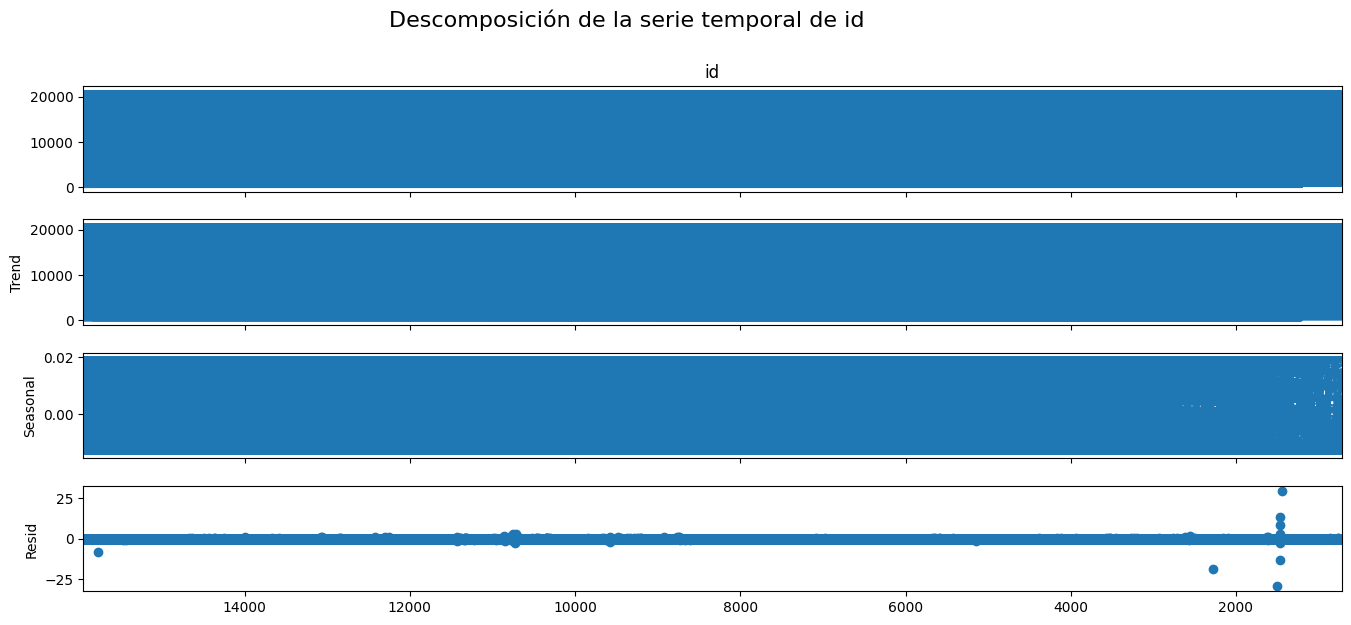

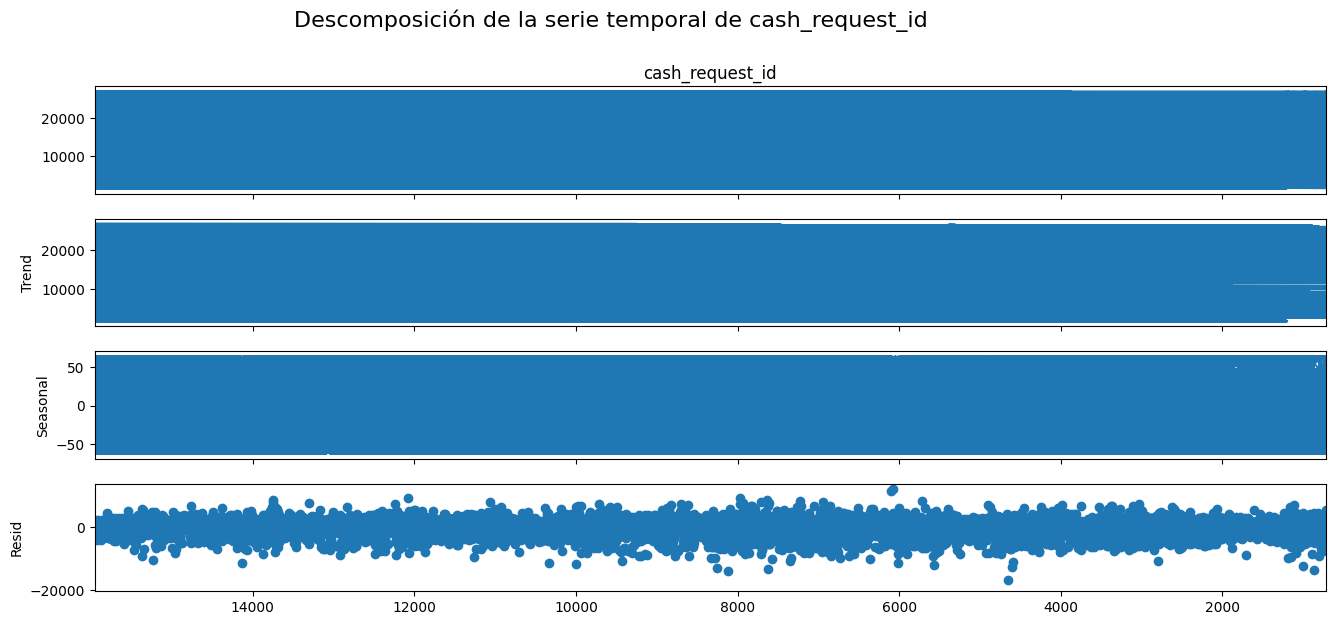

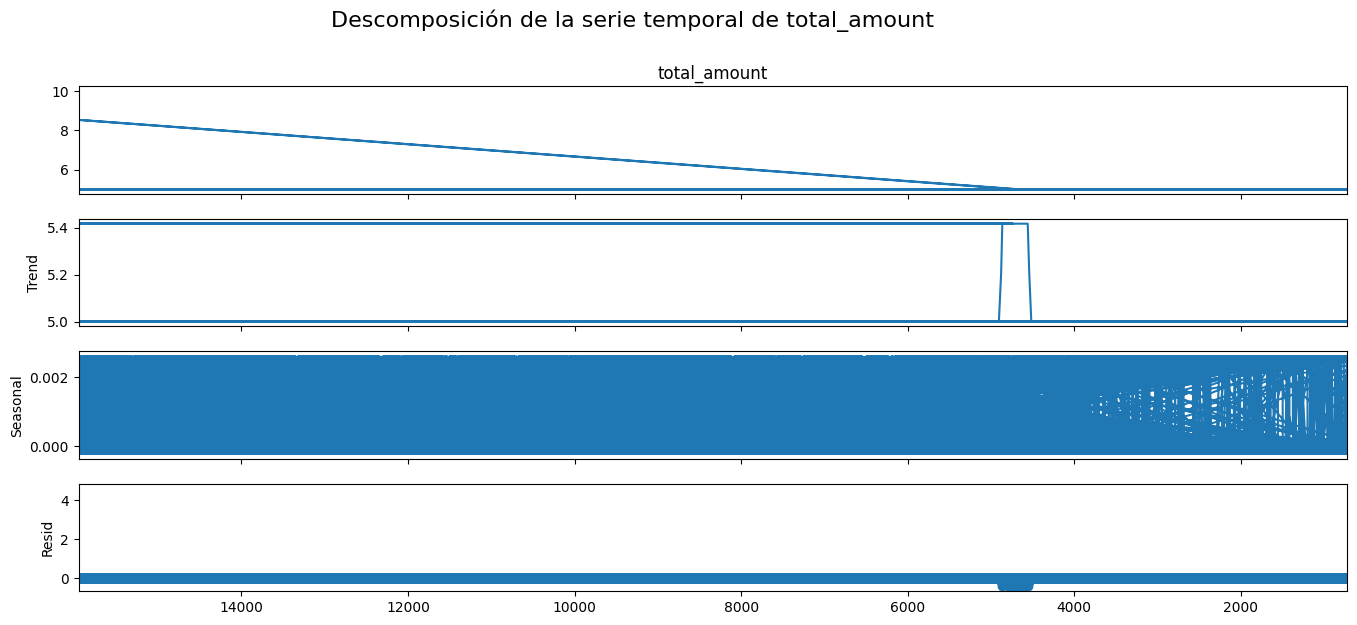

In [20]:
# Descomposición de series temporales para cada columna numérica individual
for c in columnas_numericas:
    if data[c].dtype.kind != 'M':
        # Crear una copia del DataFrame para trabajar
        data_copy = data[c].copy()
        # Verifica si hay valores faltantes y elimínalos o interpola
        if data_copy.isnull().any():
            data_copy = data_copy.interpolate() # Rellenar NaN con interpolación
        # Eliminar filas con valores faltantes
        data_copy = data_copy.dropna()
        # Verificar que no hay valores no finitos
        if not np.isfinite(data_copy).all():
            print(f'La columna {c} contiene valores no finitos, se omite la descomposición.')
            continue
        # Descomposición de la serie temporal
        descomposicion = seasonal_decompose(data_copy, model='additive', period=12)
        # Graficar la descomposición
        fig = descomposicion.plot()
        # Ajustar el tamaño de la figura con matplotlib
        plt.gcf().set_size_inches(15, 6)
        # Ajustar el título para que no se superponga
        fig.suptitle(f'Descomposición de la serie temporal de {c}', fontsize=16, y=1.05)
        plt.show()
 


## 2 Análisis de Cohortes Avanzado y la Extracción de Insights


El análisis de cohortes avanzado y la extracción de insights son componentes cruciales en el ámbit el análisis de datos y la toma de decisiones estratégicas en diversos campos,desde elmarketin igital hasta la gestión de productos y servicios.Ambos procesos permiten entender mejor el co mportamiento de los usuarios, identificar patrones significativos y tomar decisiones fundamentadas e atos. A continuación, se detallan algunas estrategias comunes para llevar a cabo estas prácticas:
### 2.1 Análisis de Cohortes Avanzado:
El análisis de cohortes se refiere a la agrupación de individuos que comparten una característic omún o que han experimentado un evento similar en un período específico de tiempo.El análisi vanzado de cohortes implica eluso de técnicas más sofisticadas para comprender mejor elcomportamiento de estos grupos a lo largo deltiempo y extraer insights valiosos.A continuación,s etallan técnicas y enfoques comunes:
1. **Refinamiento de Cohortes**
    - Segmentación adicional de cohortes: Divide los grupos en subconjuntos más específicos basados en características demográficas (edad, género, ubicación), comportamiento specíficos (frecuencia de compra, interacciones en línea) o patrones de uso (horarios d so, dispositivos utilizados).Esto permite una comprensión más profunda de los comportamientos y necesidades de diferentes grupos de usuarios.
    - Utilización de técnicas de clustering: Aplica algoritmos de agrupamiento par dentificar subgrupos dentro de las cohortes principales.Esto te permite descubrir patrones más complejos y segmentar los datos de manera más precisa,lo que facilita l ersonalización de estrategias y acciones.
2. **Análisis de Retención**
    - Seguimiento de la retención: Observa cómo cambia la cantidad de usuarios activo entro de cada cohorte a lo largo del tiempo.Esto te ayuda a comprender si los usuario ermanecen comprometidos con tu producto o servicio y a identificar posibles problema e retención.
    - Identificación de factores de retención: Examina qué factores influyen en la retención de los usuarios (como la calidad delproducto,la experiencia delusuario o la romociones).Luego,desarrolla estrategias para mejorar la retención basadas en esto allazgos,lo que puede incluir mejoras en la experiencia delusuario,ofertas especiale  programas de fidelización.
3. **Cohortes Dinámicas**
    - Creación de cohortes dinámicas: Actualiza continuamente las cohortes para refleja os cambios en el comportamiento del usuario o las características del producto.Esto t ermite mantener un seguimiento preciso de la evolución del rendimiento a lo largo de iempo y adaptar tus estrategias en consecuencia.
    - Uso de modelos predictivos: Implementa modelos que puedan predecir elcomportamiento futuro de las cohortes en función de datos históricos y variables clave.Esto t yuda a anticipar tendencias y tomar decisiones proactivas, como la personalización d fertas o la optimización de la distribución de recursos.
4. **Análisis de Recurrencia**
    - Estudio de la frecuencia de retorno: Analiza qué tan a menudo los usuarios regresa espués de su primera interacción con tu producto o servicio.Esto te permite entende a lealtad del cliente y su propensión a continuar utilizando tu oferta.
    - Identificación de patrones recurrentes: Busca patrones en el comportamiento de lo suarios que indican una alta probabilidad de regreso, como la frecuencia de compra o l articipación en actividades específicas.Estos patrones pueden ser clave para desarrolla strategias efectivas de retención y compromiso.
5. **Análisis de Comportamiento**
    - Seguimiento del comportamiento individual: Examina cómo se comportan lo suarios dentro de cada cohorte a lo largo deltiempo. Esto te ayuda a identifica endencias, cambios de comportamiento y momentos clave en el ciclo de vida del usuario,
1 o que puede informar la optimización de la experiencia del usuario y la personalizació e las estrategias de marketing.
    - Identificación de patrones y puntos de inflexión: Busca momentos en los que e omportamiento de los usuarios cambie significativamente, como la adopción de nueva aracterísticas o la disminución de la actividad.Estos puntos de inflexión pueden se portunidades para la intervención y la mejora continua del producto o servicio.
### 2.2 Extracción de Insights:
La extracción de insights implica el proceso de identificar y comprender información significativa y útil a partir de los datos analizados.A continuación, se detallan algunas estrategias comunes par xtraer insights del análisis de cohortes:
1. **Segmentación Avanzada**
    - Segmentación detallada de las cohortes: Divide los grupos en segmentos más específicos basados en características compartidas o comportamientos similares.Esto t ermite personalizar tus estrategias para satisfacer las necesidades únicas de cada segmento, lo que puede mejorar la efectividad de tus acciones y campañas.
    - Personalización de estrategias: Utiliza los segmentos identificados para adaptar tu strategias de marketing,comunicación y experiencia delusuario, lo que aumenta l elevancia y la efectividad de tus acciones y mejora la satisfacción del cliente.
2. **Identificación de Tendencias**
    - Detección de tendencias a lo largo del tiempo: Analiza cómo evolucionan la étricas clave (como la retención o el compromiso) dentro de cada cohorte con el tiempo.
Esto te ayuda a identificar patrones y entender cómo ciertos eventos o cambios afecta l comportamiento de los usuarios, lo que puede informar decisiones estratégicas futuras.
    - Análisis de eventos específicos: Examina cómo eventos como lanzamientos de productos, campañas de marketing o cambios en el diseño impactan en el comportamient e las cohortes.Esto te proporciona información valiosa para la planificación futura  a evaluación del éxito de tus iniciativas.
3. **Predicción y Modelado**
    - Utilización de modelos predictivos: Implementa modelos que puedan predecir e omportamiento futuro de las cohortes en función de datos históricos y variables clave.
Esto te ayuda a anticipar tendencias y tomar decisiones informadas sobre estrategia uturas, lo que puede aumentar la eficiencia y el éxito de tus acciones.
    - Evaluación de impacto: Evalúa el impacto potencialde cambios en productos,servicios o estrategias antes de implementarlos.Esto te permite tomar decisiones má ólidas y minimizar los riesgos asociados con nuevas iniciativas, lo que puede mejorar l entabilidad y la satisfacción del cliente a largo plazo.
4. **Benchmarking y Comparación**
    - Comparación del rendimiento: Compara el rendimiento de diferentes cohortes  egmentos de usuarios para identificar áreas de fortaleza y oportunidades de mejora.
Esto te ayuda a entender tu posición en el mercado y a identificar estrategias par iferenciarte y destacarte entre la competencia.
    - Benchmarking contra competidores: Compara tus métricas con las de tus competidores o estándares de la industria para entender tu posición en el mercado y encontra portunidades para diferenciarte.Esto te proporciona información valiosa sobre la ejores prácticas y te ayuda a identificar áreas de mejora y oportunidades de crec1 miento.
5. **Acciones Estratégicas**
    - Desarrollo de estrategias específicas: Utiliza los insights obtenidos para desarrolla strategias específicas destinadas a mejorar la retención, el compromiso y el crecimient e tu negocio.Esto puede incluir cambios en productos o servicios, ajustes en la estrategia de marketing o mejoras en la experiencia del cliente.
    - Evaluación continua: Evalúa regularmente la efectividad de tus estrategias a travé el análisis de cohortes en curso y realiza ajustes según sea necesario para optimizar lo esultados a lo largo del tiempo.Esto te permite adaptarte a los cambios en el mercad  mantener una ventaja competitiva a largo plazo.


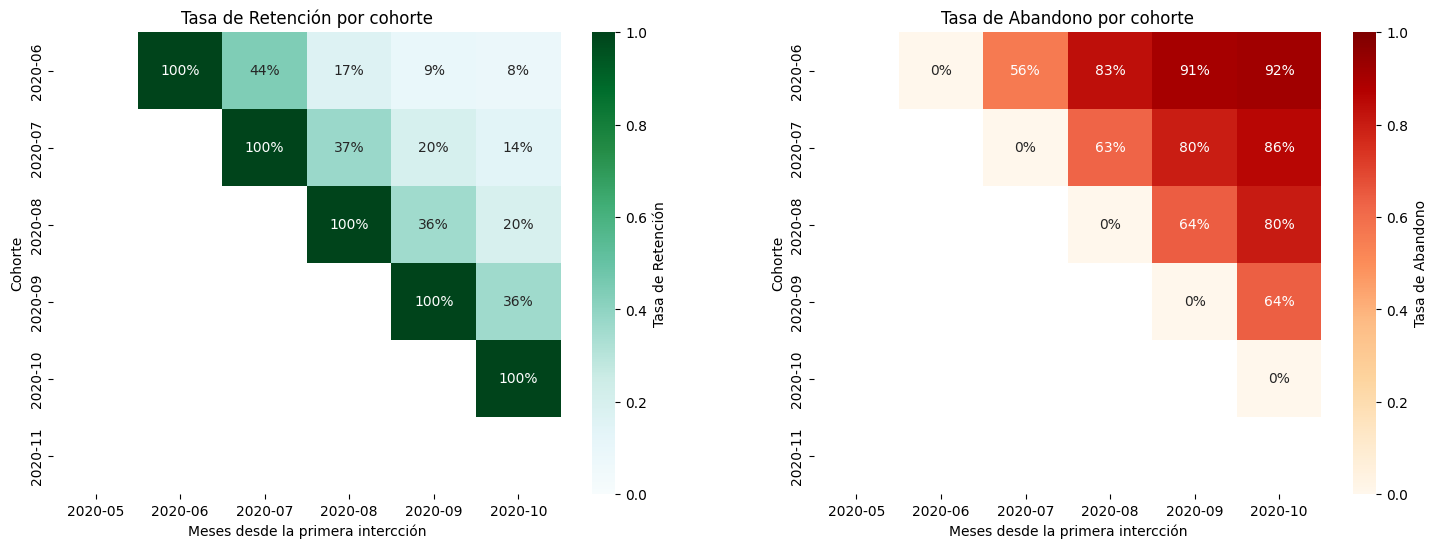

In [22]:
def retention_rate_monthly(cr, field_id, field_date, delete_last=True, title='por cohorte'):
    # Crear columna 'Mes' indicando el mes de cada intercción
    cr['Mes'] = cr[field_date].dt.to_period('M')
    # Crear columna 'Cohorte' que indica el mes de la primera intercción de cada id
    cr['Cohorte'] = cr.groupby(field_id)[field_date].transform('min').dt.to_period('M')
    # Calcular el número inicial de field_id únicos en cada cohorte
    cohort_sizes_initial = cr.groupby('Cohorte').agg(Num_id_Iniciales=(field_id, 'nunique')).reset_index()
    # Calcular la cantidad de field_id únicos en cada cohorte para cada mes
    cohort_sizes_monthly = cr.groupby(['Cohorte', 'Mes']).agg(Num_id=(field_id, 'nunique')).reset_index()
    # Calcular la tasa de retención de field_id (field_id únicos por cohorte en cada mes / field_id iniciales de la cohorte) 
    retention = cohort_sizes_monthly.pivot(index='Cohorte', columns='Mes',values='Num_id')
    retention = retention.div(cohort_sizes_initial.set_index('Cohorte')['Num_id_Iniciales'], axis=0)
    retention = retention.iloc[1:, :-1] if delete_last else retention
    # Calcular la tasa de abandono de field_id (1 - tasa de retención)
    churn = 1 - retention

    if retention.empty:
        print(f'No existen registros para {field_id} '+ title)
        return 0

    fig, axs = plt.subplots(1, 2, figsize=(18, 6))
    # Visualizar la tasa de retención de field_id usando un mapa de calor
    axs[0].set_title(f'Tasa de Retención ' + title)
    sns.heatmap(data=retention, annot=True, fmt='.0%', vmin=0.0, vmax=1.0,cmap='BuGn', cbar_kws={'label': 'Tasa de Retención'}, ax=axs[0])
    axs[0].set_xlabel('Meses desde la primera intercción')
    axs[0].set_ylabel('Cohorte')

    # Visualizar la tasa de abandono de field_id usando un mapa de calor
    axs[1].set_title(f'Tasa de Abandono ' + title)
    sns.heatmap(data=churn, annot=True, fmt='.0%', vmin=0.0, vmax=1.0,cmap='OrRd', cbar_kws={'label': 'Tasa de Abandono'}, ax=axs[1])
    axs[1].set_xlabel('Meses desde la primera intercción')
    axs[1].set_ylabel('Cohorte')
    plt.show()

retention_rate_monthly(data.copy(), 'cash_request_id', 'created_at')

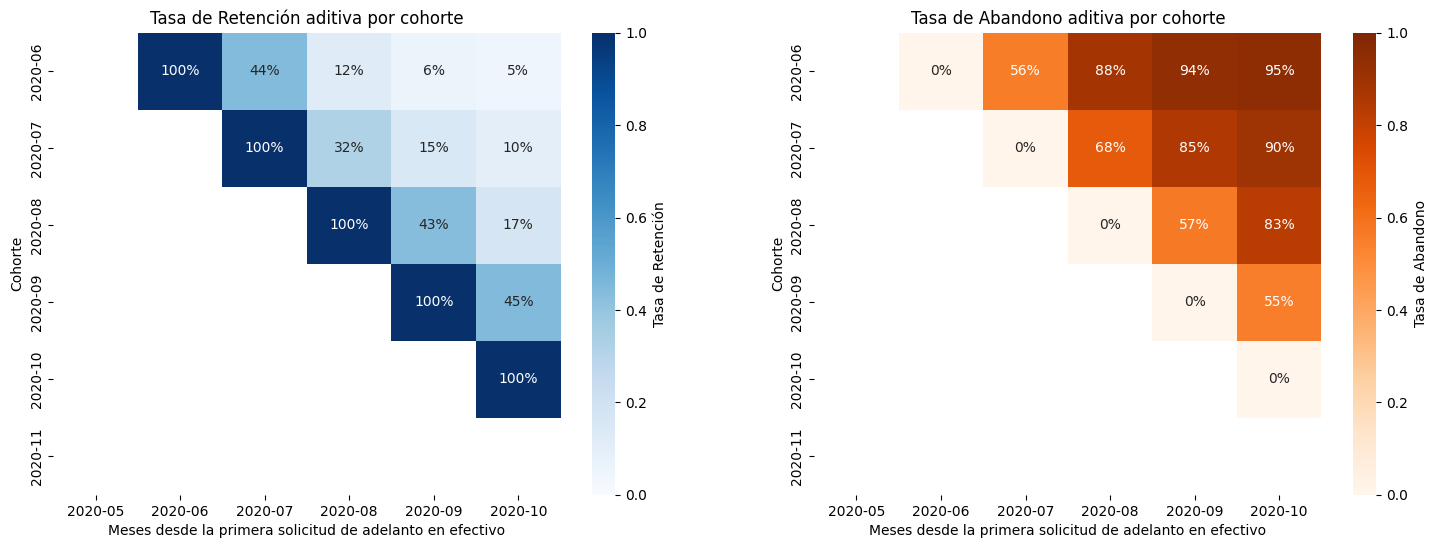

In [24]:
def retention_rate_solicit_monthly(cr, field_id, field_date, delete_last=True, title='por cohorte'):

    # Crear columna 'Mes' indicando el mes de cada intercción
    cr['Mes'] = cr[field_date].dt.to_period('M')
    # Crear columna 'Cohorte' que indica el mes de la primera intercción de cada id
    cr['Cohorte'] = cr.groupby(field_id)[field_date].transform('min').dt.to_period('M')
    # Calcular la cantidad de solicitudes de adelanto de efectivo de los clientes de cada cohorte en cada mes
    cohort_cash_monthly = cr.groupby(['Cohorte', 'Mes']).agg(Num_Solicitudes=(field_id, 'count')).reset_index()
    # Calcular el número inicial de solicitudes de adelanto de efectivo en cada cohorte
    cohort_cash_initial = cohort_cash_monthly.groupby('Cohorte').first().reset_index().rename(columns={'Num_Solicitudes':'Num_Solicitudes_Iniciales'})
    # Calcular la tasa de retención de solicitudes (solicitudes por cohorte en cada mes / solicitudes iniciales de la cohorte)
    retention_cash = cohort_cash_monthly.pivot(index='Cohorte', columns='Mes',values='Num_Solicitudes')
    retention_cash = retention_cash.div(cohort_cash_initial.set_index('Cohorte')['Num_Solicitudes_Iniciales'], axis=0)
    retention_cash = retention_cash.iloc[1:, :-1] if delete_last else retention_cash

    # Calcular la tasa de abandono de solicitudes (1 - tasa de retención de solicitudes)
    churn_cash = 1 - retention_cash

    if retention_cash.empty:
        print(f'No existen registros para {field_id} '+ title)
        return 0
        
    fig, axs = plt.subplots(1, 2, figsize=(18, 6))
    # Visualizar la tasa de retención de solicitudes usando un mapa de calor
    axs[0].set_title('Tasa de Retención aditiva '+title)
    sns.heatmap(data=retention_cash, annot=True, fmt='.0%', vmin=0.0, vmax=1.0,cmap='Blues', cbar_kws={'label': 'Tasa de Retención'}, ax=axs[0])
    axs[0].set_xlabel('Meses desde la primera solicitud de adelanto en efectivo')
    axs[0].set_ylabel('Cohorte')

    # Visualizar la tasa de abandono de solicitudes usando un mapa de calor
    axs[1].set_title('Tasa de Abandono aditiva '+title)
    sns.heatmap(data=churn_cash, annot=True, fmt='.0%', vmin=0.0, vmax=1.0,cmap='Oranges', cbar_kws={'label': 'Tasa de Abandono'}, ax=axs[1])
    axs[1].set_xlabel('Meses desde la primera solicitud de adelanto en efectivo')
    axs[1].set_ylabel('Cohorte')
    plt.show()

retention_rate_solicit_monthly(data.copy(), 'cash_request_id', 'created_at')

cash_request_id únicos con type = postpone: 4057
cash_request_id en otro registro con type = postpone: 11352


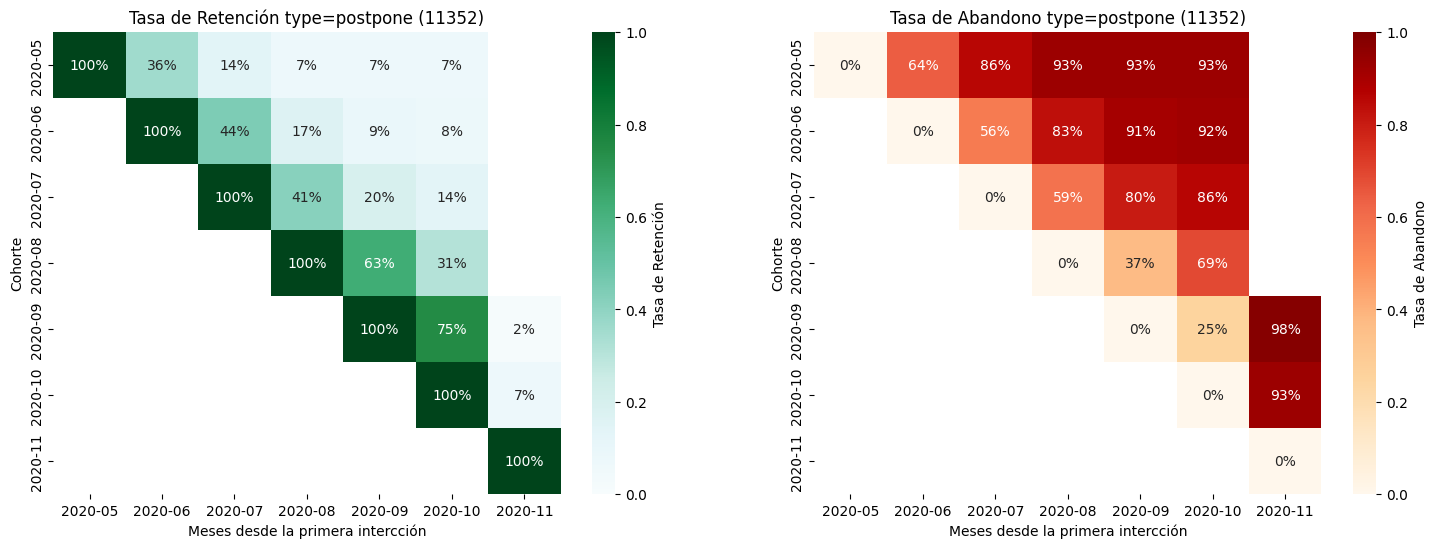

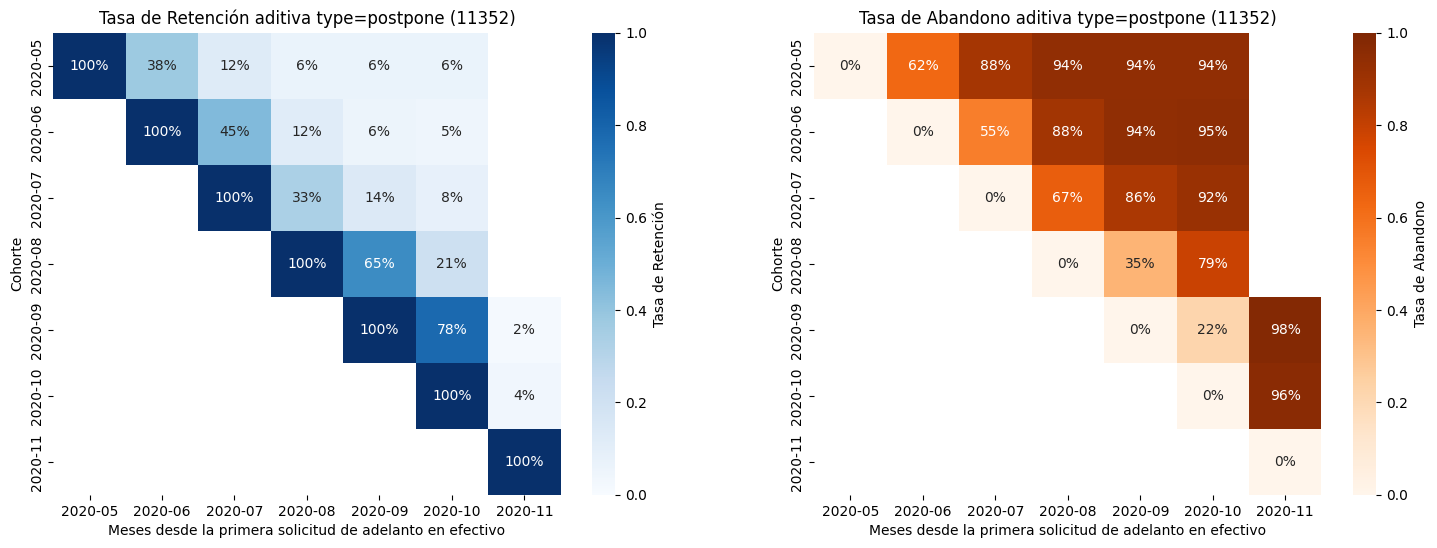

cash_request_id únicos con type = incident: 684
cash_request_id en otro registro con type = incident: 2967


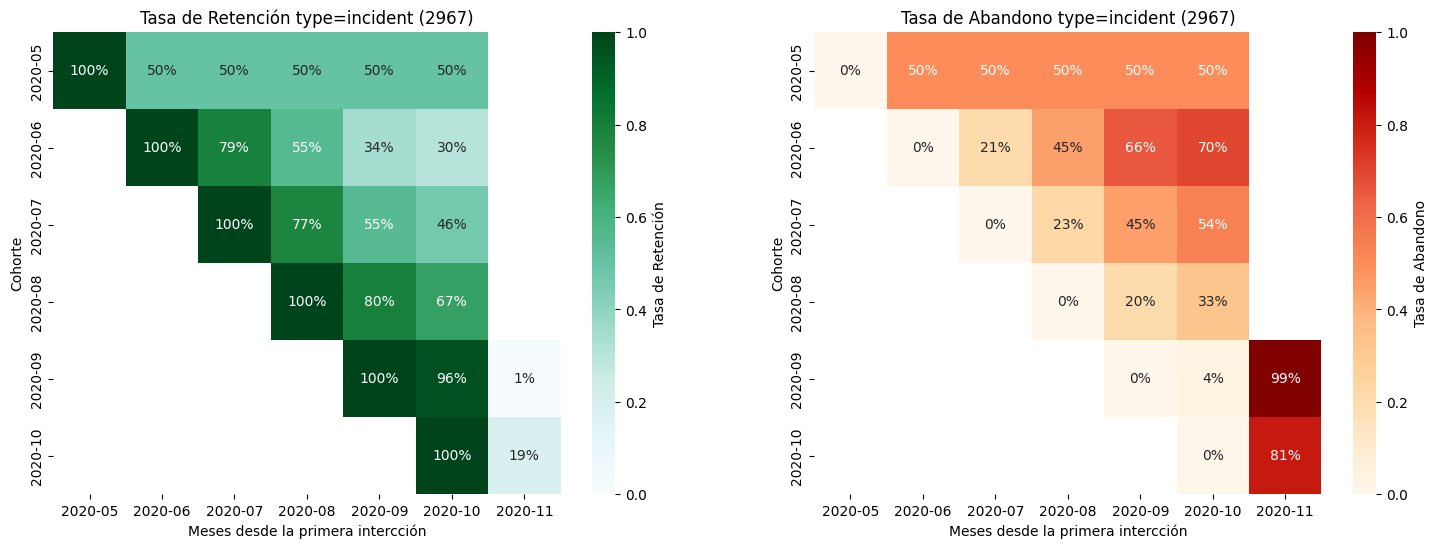

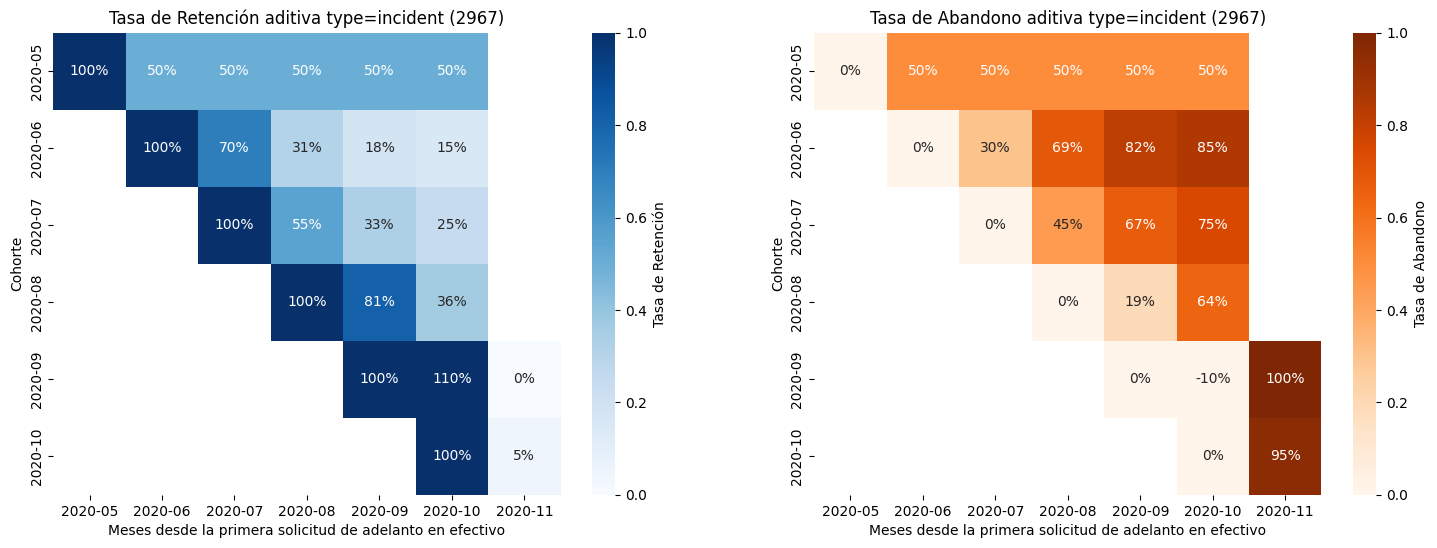

cash_request_id únicos con type = instant_payment: 306
cash_request_id en otro registro con type = instant_payment: 1384


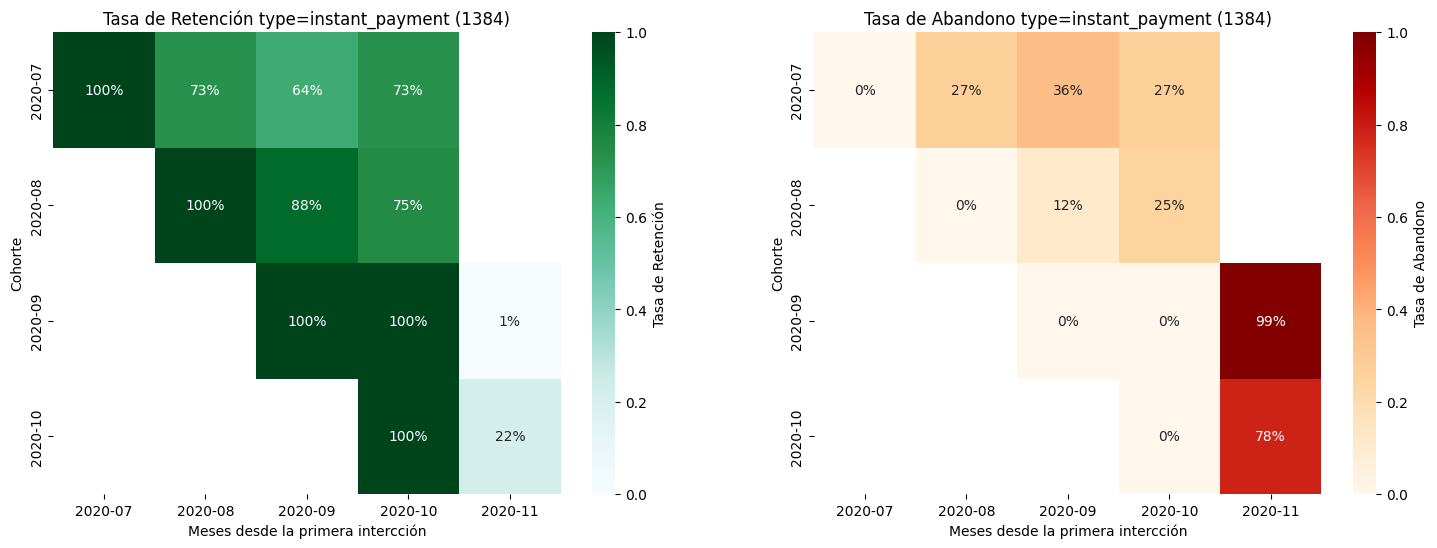

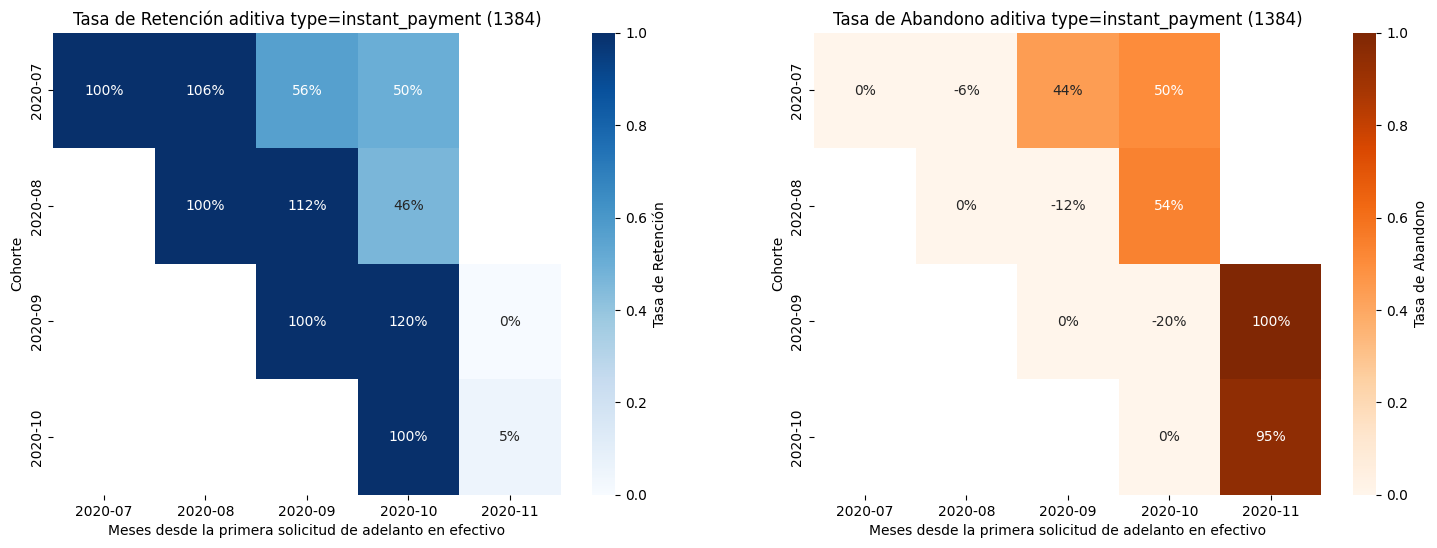

cash_request_id únicos con status = cancelled: 2357
cash_request_id en otro registro con status = cancelled: 8027


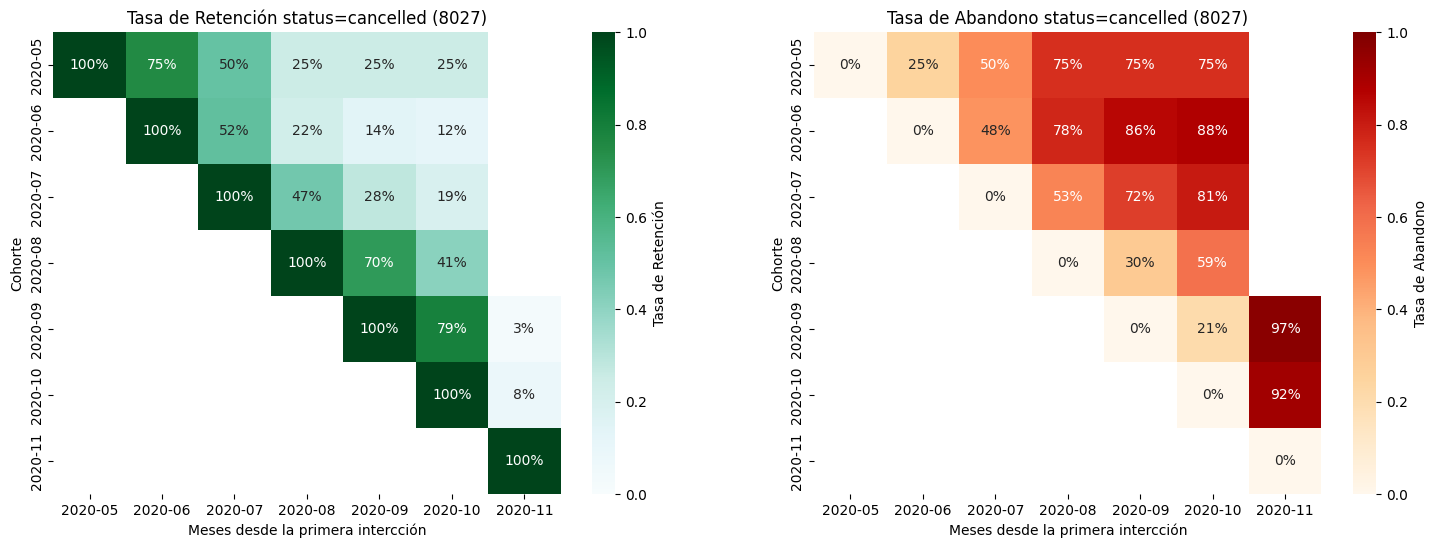

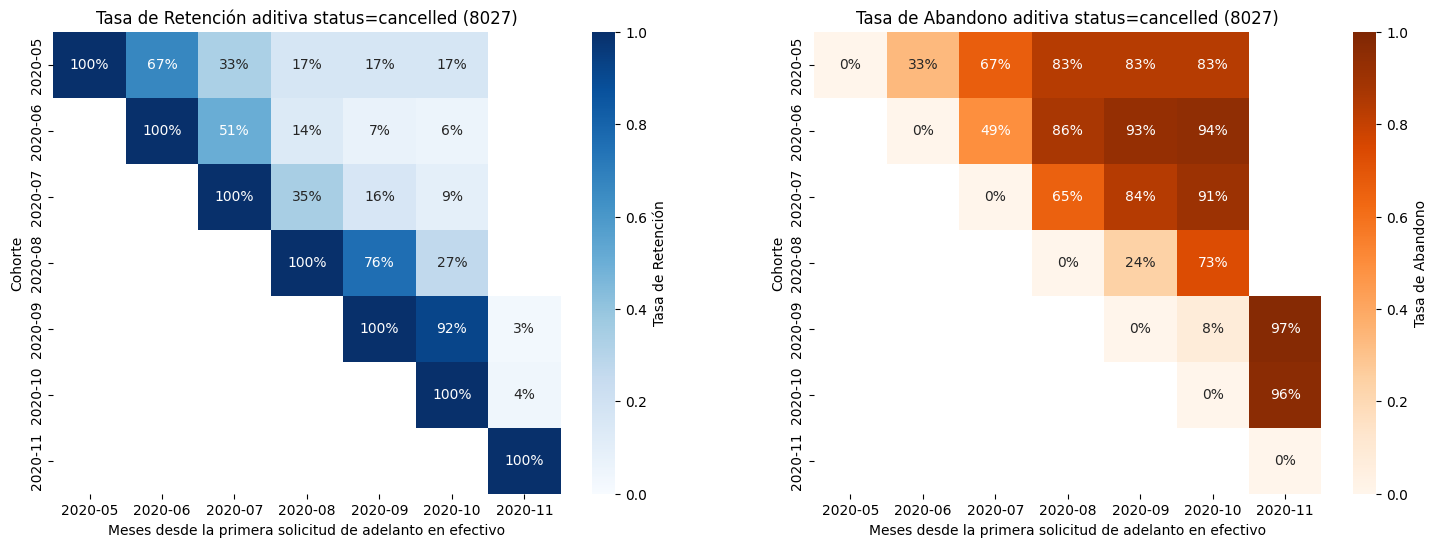

cash_request_id únicos con status = accepted: 1793
cash_request_id en otro registro con status = accepted: 6521


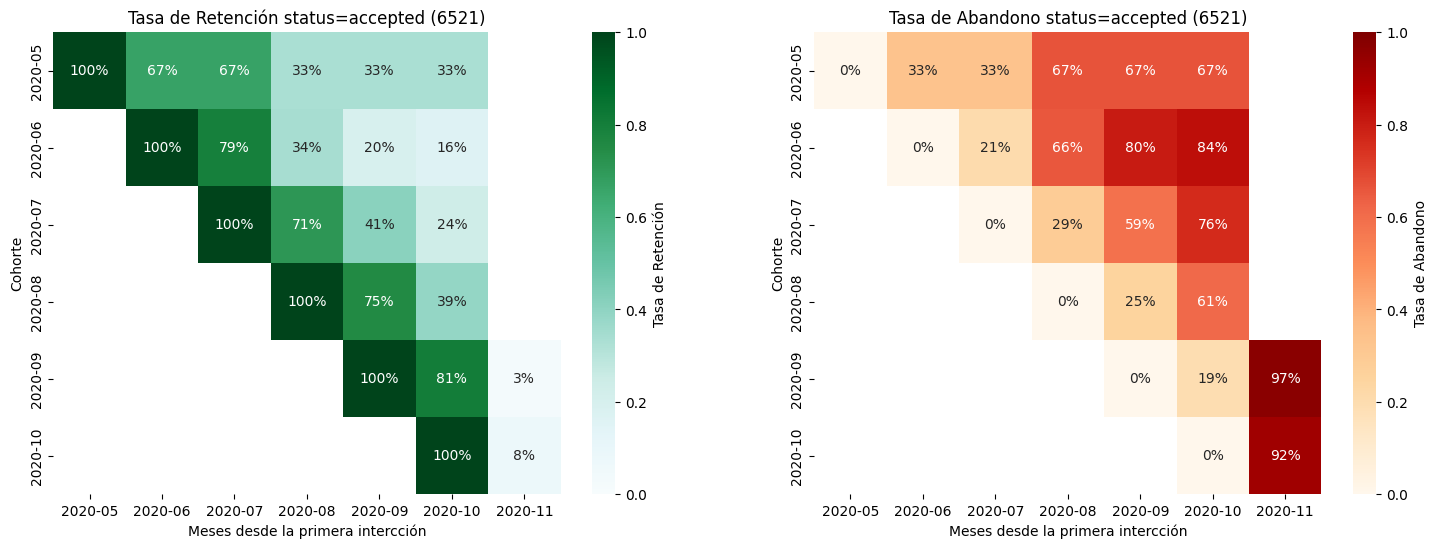

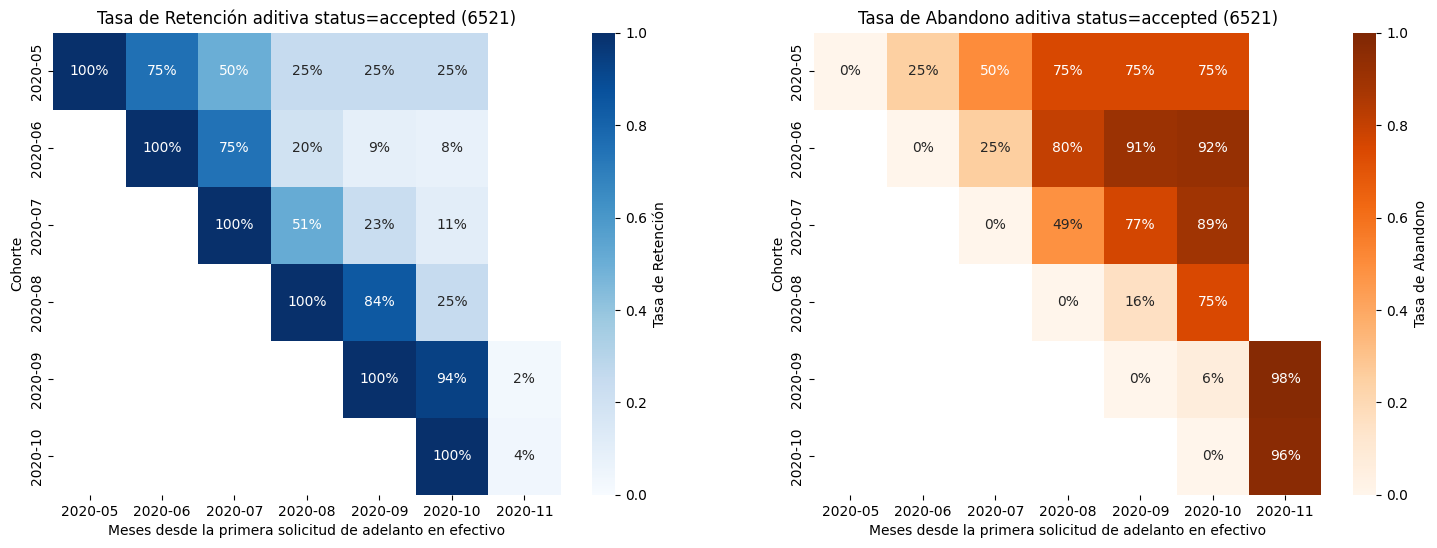

cash_request_id únicos con status = rejected: 81
cash_request_id en otro registro con status = rejected: 402


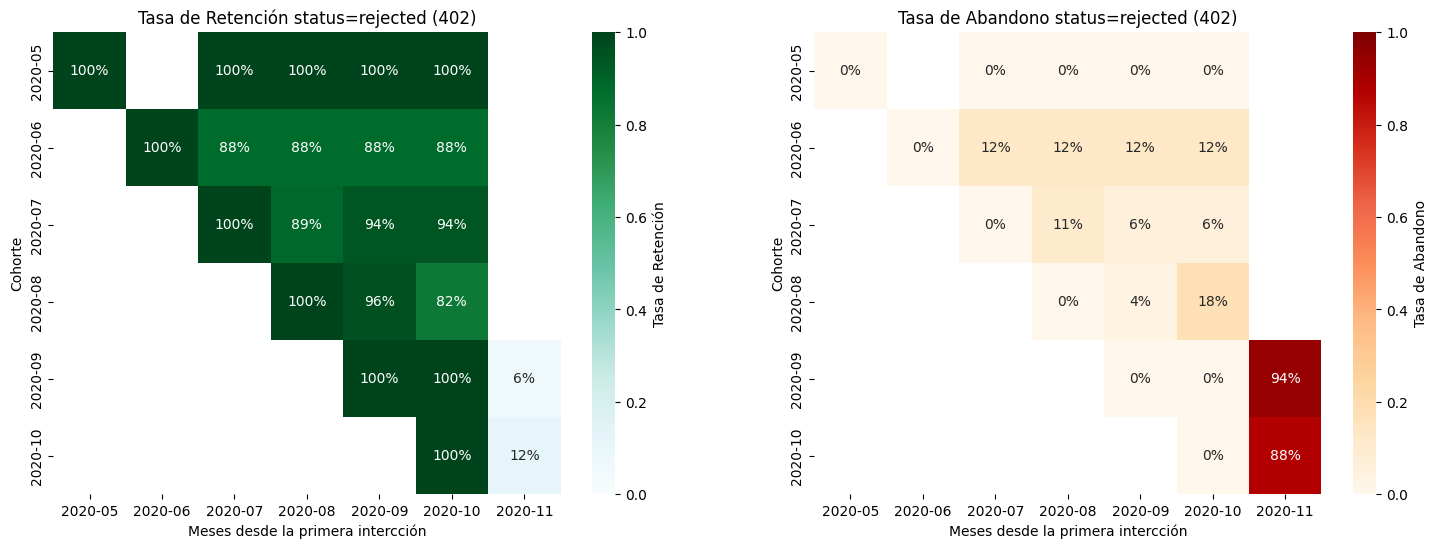

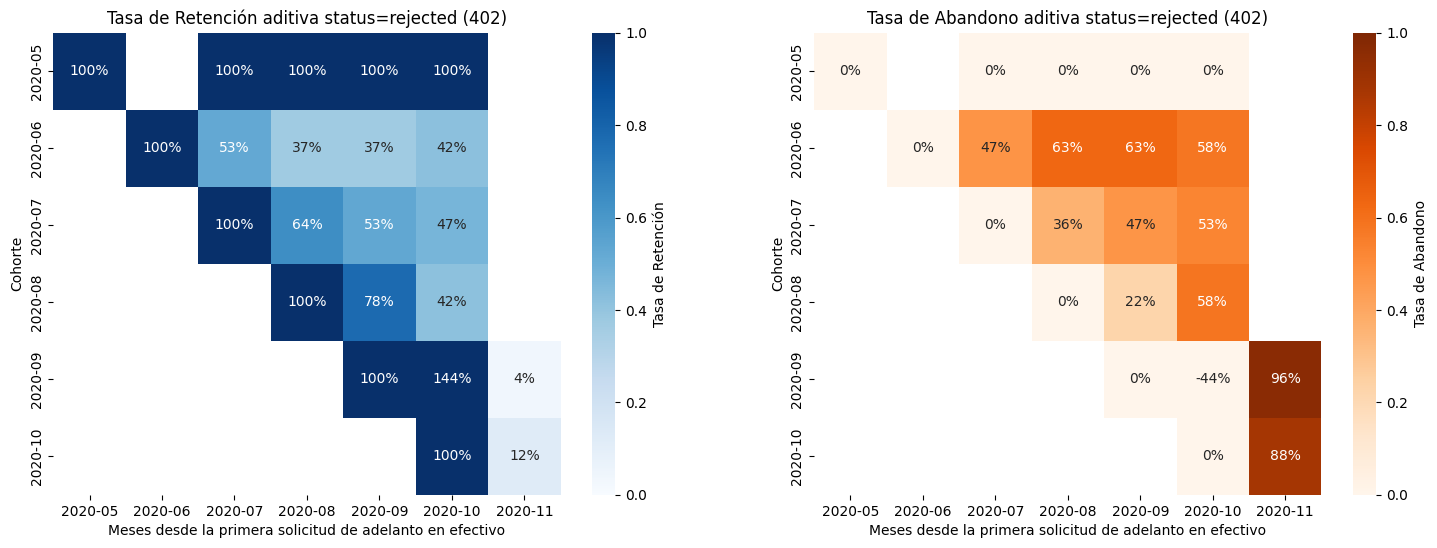

cash_request_id únicos con status = confirmed: 1
cash_request_id en otro registro con status = confirmed: 5


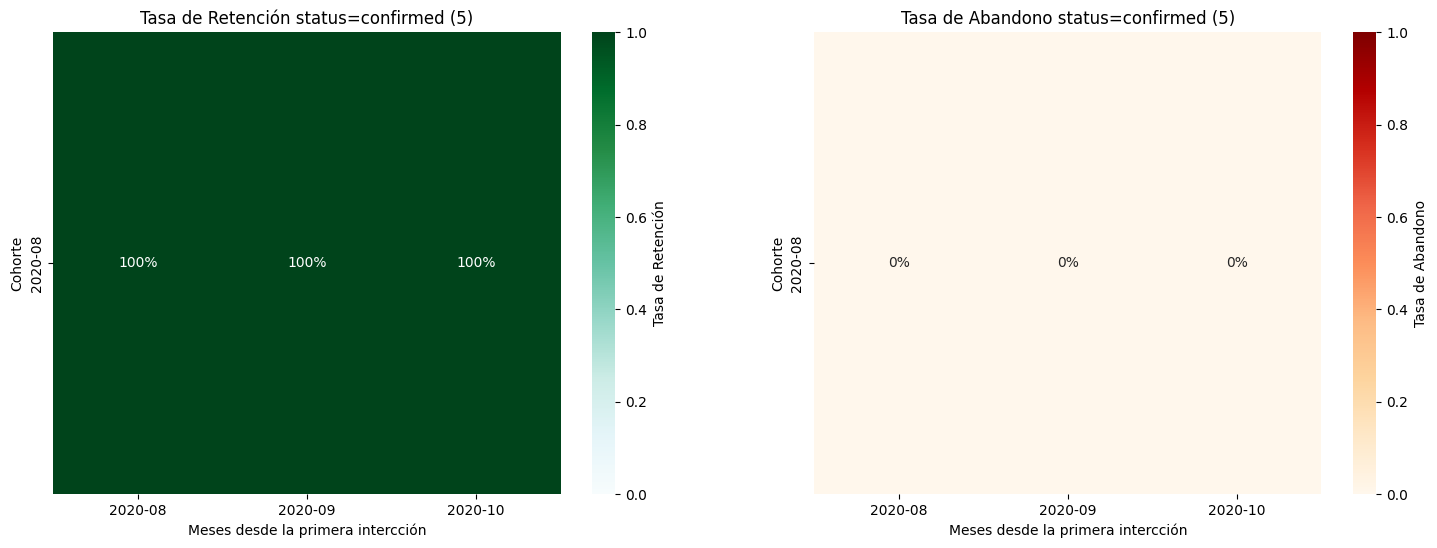

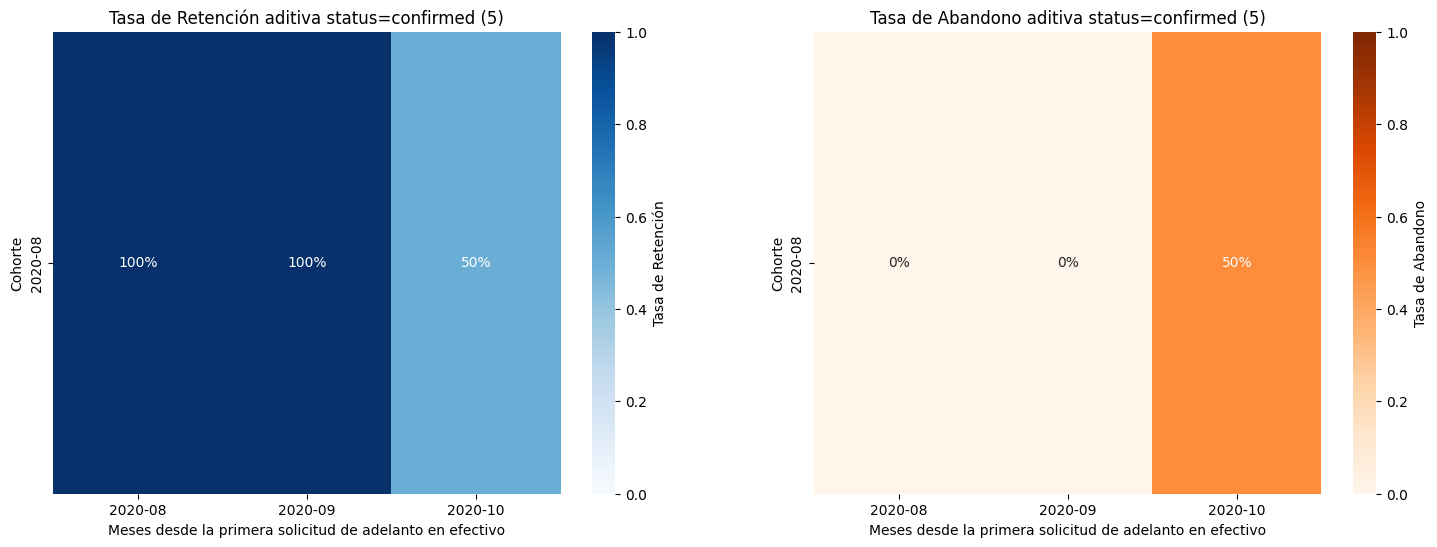

cash_request_id únicos con category = nan: 0
cash_request_id en otro registro con category = nan: 0
cash_request_id únicos con category = rejected_direct_debit: 0
cash_request_id en otro registro con category = rejected_direct_debit: 0
cash_request_id únicos con category = month_delay_on_payment: 0
cash_request_id en otro registro con category = month_delay_on_payment: 0
cash_request_id únicos con reason = Postpone Cash Request: 4057
cash_request_id en otro registro con reason = Postpone Cash Request: 11352


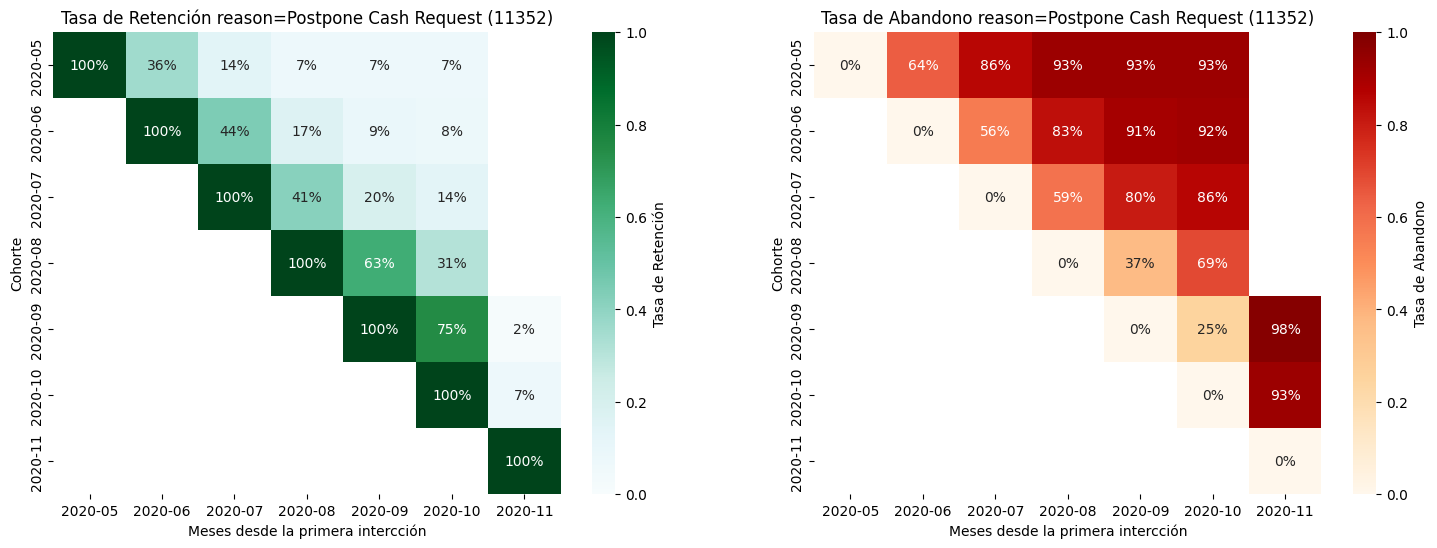

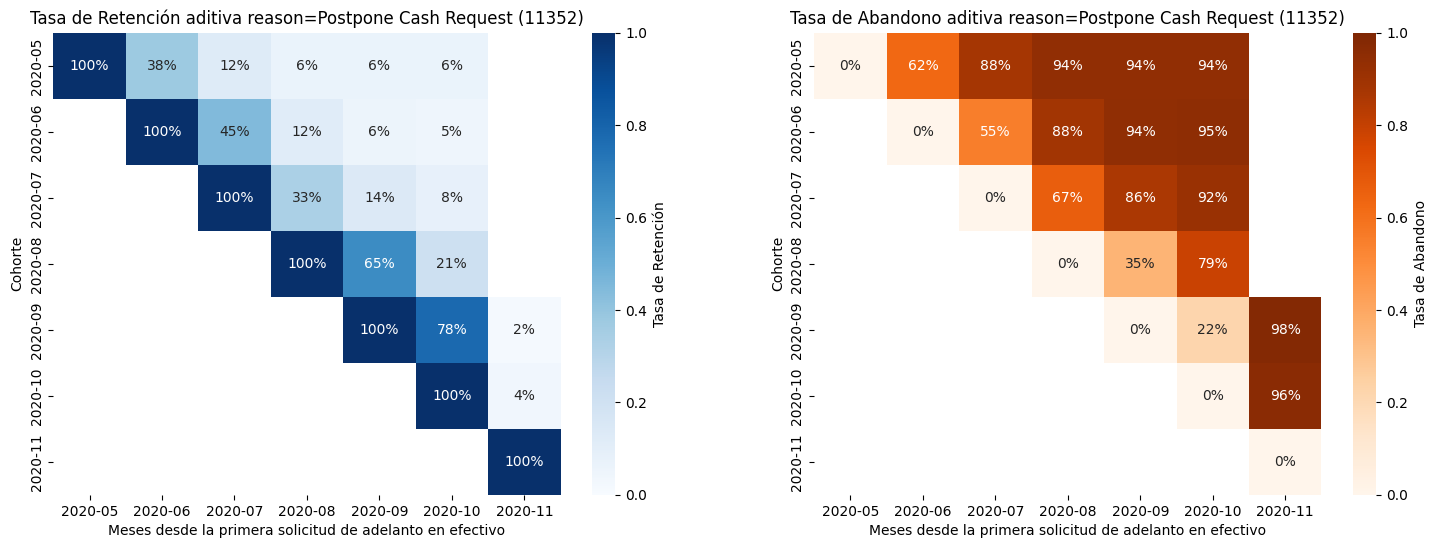

cash_request_id únicos con reason = rejected direct debit: 683
cash_request_id en otro registro con reason = rejected direct debit: 2962


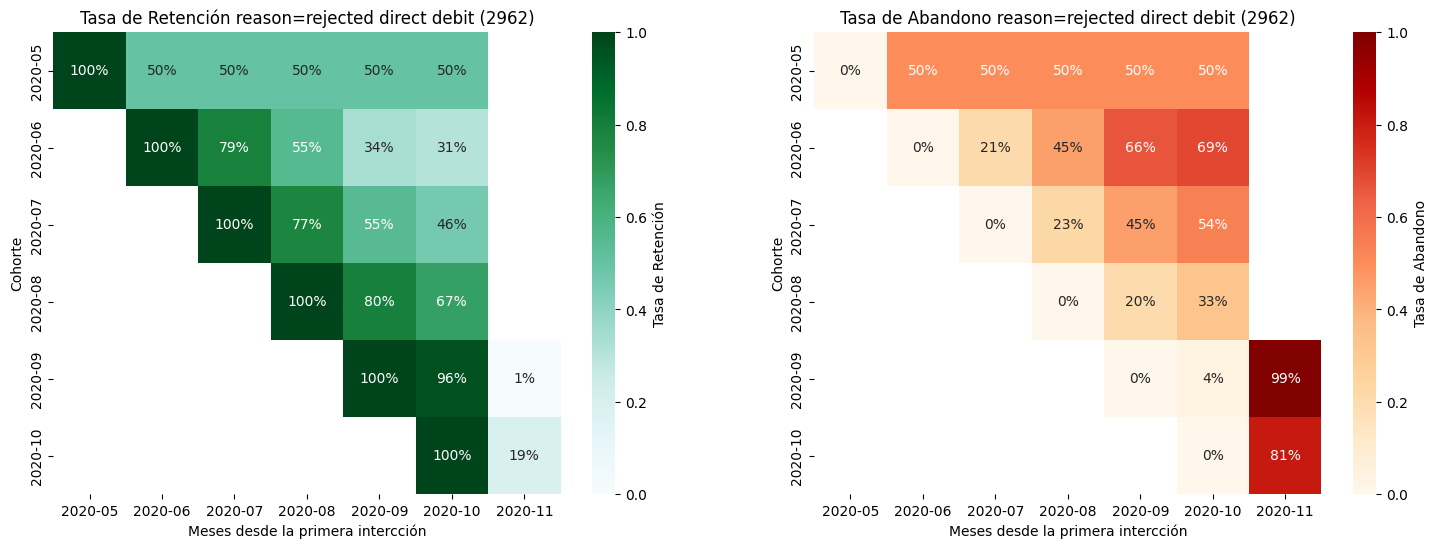

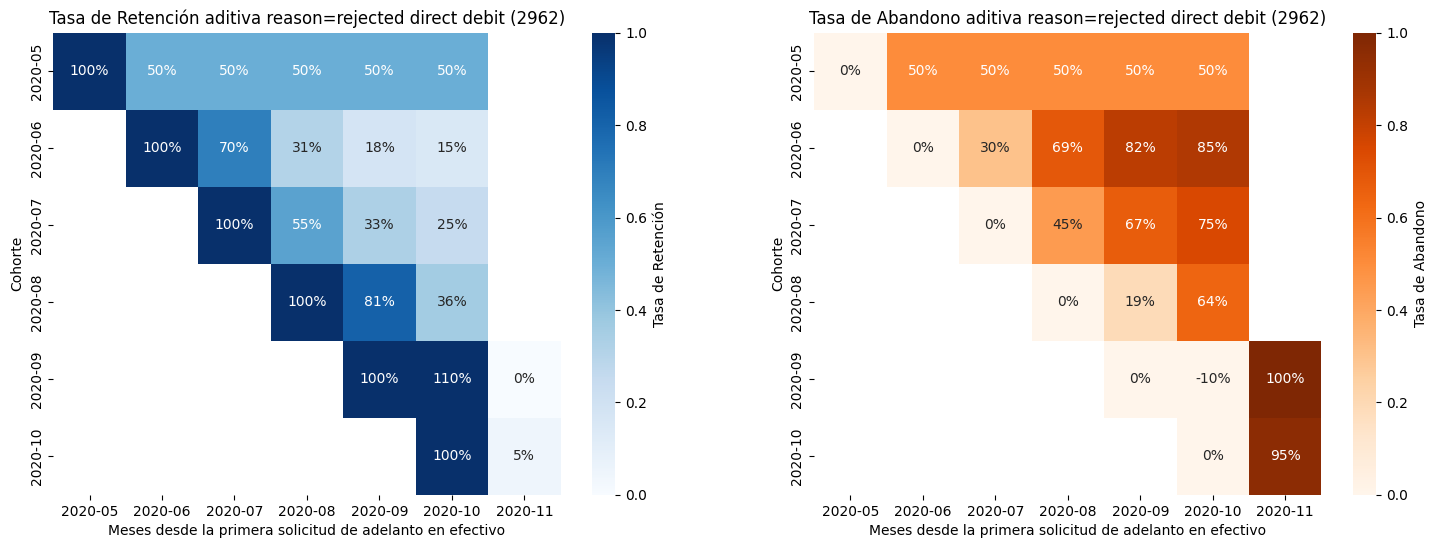

cash_request_id únicos con reason = Instant Payment Cash Request: 306
cash_request_id en otro registro con reason = Instant Payment Cash Request: 1384


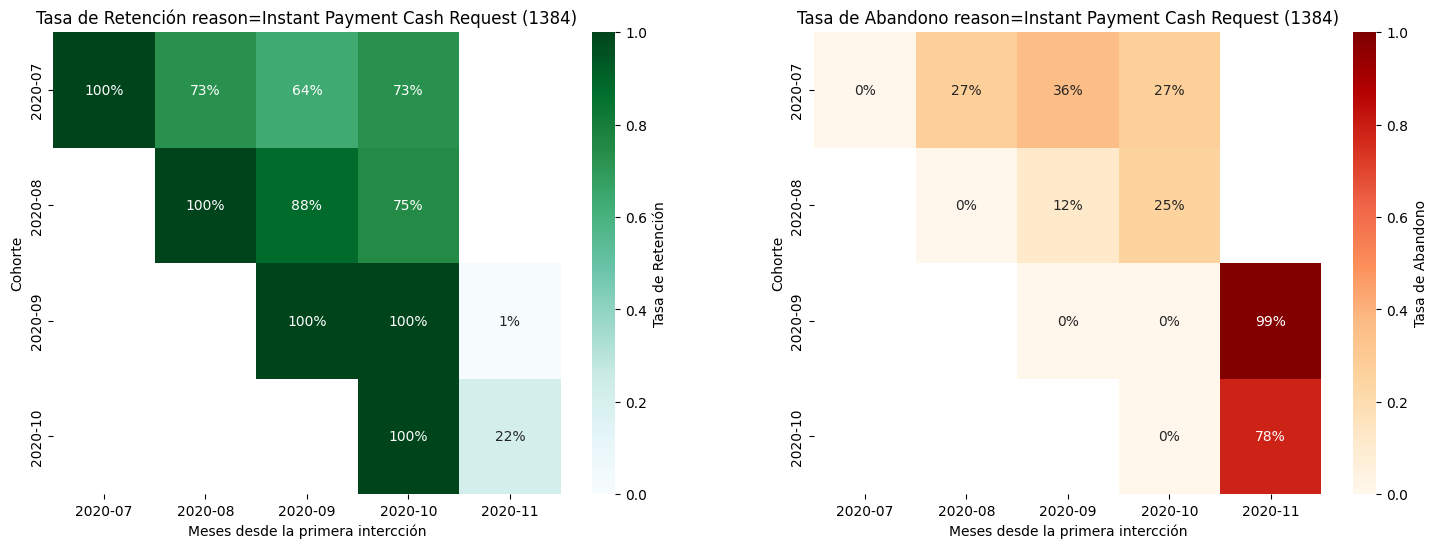

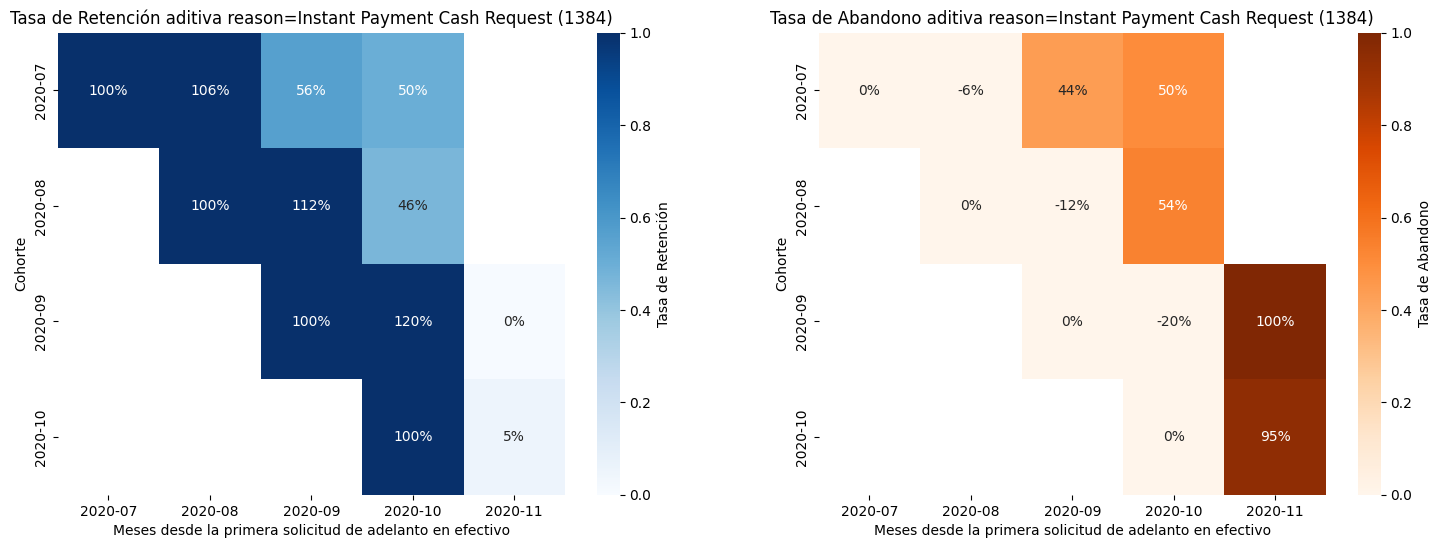

cash_request_id únicos con reason = month delay on payment: 25
cash_request_id en otro registro con reason = month delay on payment: 157


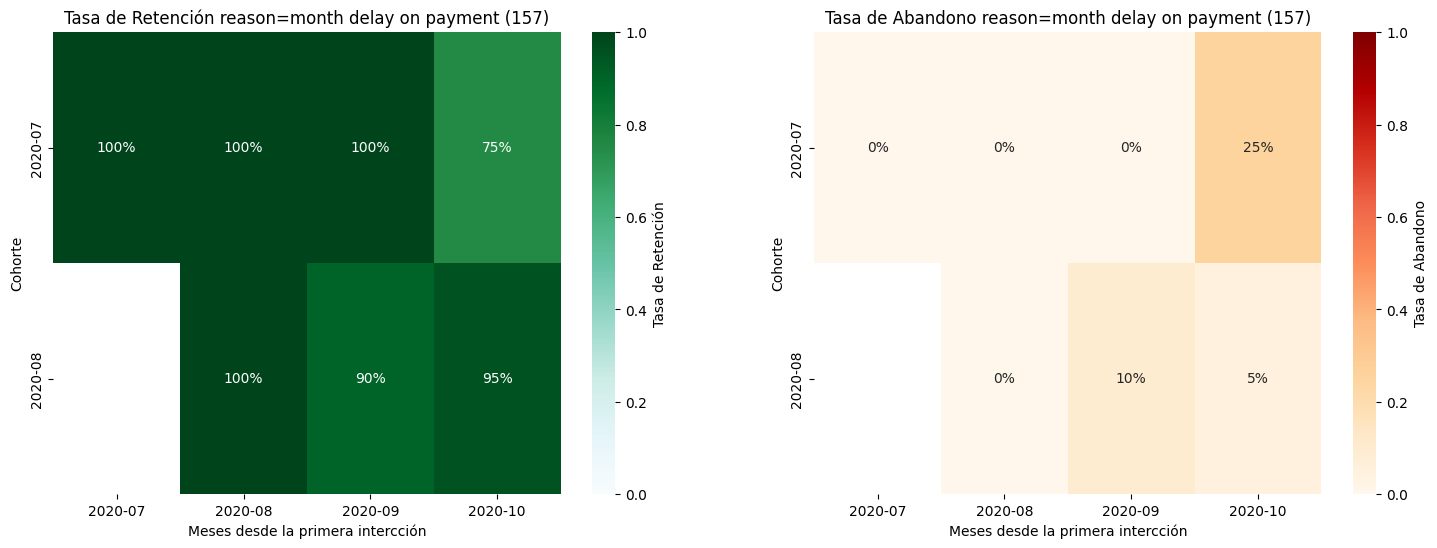

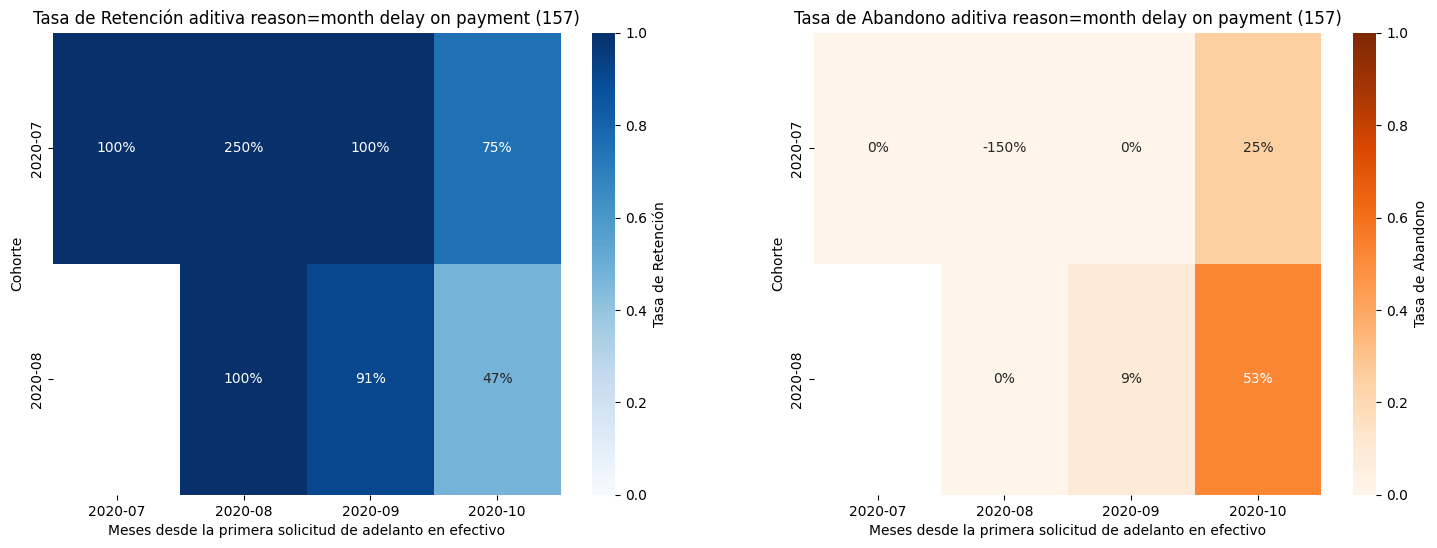

In [47]:
def category_cohort(df, cohort_column, id_column, date_column):
    for cohort_value in df[cohort_column].unique():
        cohort_id = df[df[cohort_column] == cohort_value][id_column].unique()
        print(f'{id_column} únicos con {cohort_column} = {cohort_value}: {len(cohort_id)}')
        df = df[df[id_column].isin(cohort_id)]
        print(f'{id_column} en otro registro con {cohort_column} = {cohort_value}: {len(df)}')
        if len(df) > 0 :
            retention_rate_monthly(df, id_column, date_column, False, f'{cohort_column}={cohort_value} ({len(df)})')
            retention_rate_solicit_monthly(df, id_column, date_column, False, f'{cohort_column}={cohort_value} ({len(df)})')

for c in data.columns.tolist():
    if c not in columnas_numericas:
        category_cohort(data.copy(), c, 'cash_request_id', 'created_at')
        